# Can you predict the strength of concrete?

![concrete.jpg](images/concrete.jpg)

## Competition Brief

📖 **Background**
You work in the civil engineering department of a major university. You are part of a project testing the strength of concrete samples. 

Concrete is the most widely used building material in the world. It is a mix of cement and water with gravel and sand. It can also include other materials like fly ash, blast furnace slag, and additives. 

The compressive strength of concrete is a function of components and age, so your team is testing different combinations of ingredients at different time intervals. 

The project leader asked you to find a simple way to estimate strength so that students can predict how a particular sample is expected to perform.

💾 **The data**
The team has already tested more than a thousand samples ([source](https://archive.ics.uci.edu/ml/datasets/concrete+compressive+strength)):

**Compressive strength data:**
- "cement" - Portland cement in kg/m3
- "slag" - Blast furnace slag in kg/m3
- "fly_ash" - Fly ash in kg/m3
- "water" - Water in liters/m3
- "superplasticizer" - Superplasticizer additive in kg/m3
- "coarse_aggregate" - Coarse aggregate (gravel) in kg/m3
- "fine_aggregate" - Fine aggregate (sand) in kg/m3
- "age" - Age of the sample in days
- "strength" - Concrete compressive strength in megapascals (MPa)

Acknowledgments: *I-Cheng Yeh, "Modeling of strength of high-performance concrete using artificial neural networks," Cement and Concrete Research, Vol. 28, No. 12, pp. 1797-1808 (1998)*.

💪 **Challenge**
Provide your project leader with a formula that estimates the compressive strength. Include:

1. The average strength of the concrete samples at 1, 7, 14, and 28 days of age.
2. The coefficients $\beta_{0}$, $\beta_{1}$ ... $\beta_{8}$, to use in the following formula: 

$$ Concrete \ Strength = \beta_{0} \ + \ \beta_{1}*cement \ + \ \beta_{2}*slag \ + \ \beta_{3}*fly \ ash  \ + \ \beta_{4}*water \ + $$ 
$$ \beta_{5}*superplasticizer \ + \ \beta_{6}*coarse \ aggregate \ + \ \beta_{7}*fine \ aggregate \ + \ \beta_{8}*age $$

## Preliminaries

In [1]:
# suppress warnings
# options(warn=-1)

In [2]:
install.packages(c("corrplot", "cowplot", "GGally", "ggpubr", "glmnet", "multilevelmod", "vip"))

Installing corrplot [0.92] ...
	OK [linked cache]
Installing cowplot [1.1.1] ...
	OK [linked cache]
Installing GGally [2.1.2] ...
	OK [linked cache]
Installing ggpubr [0.4.0] ...
	OK [linked cache]
Installing glmnet [4.1-4] ...
	OK [linked cache]
Installing multilevelmod [0.2.0] ...
	OK [linked cache]
Installing vip [0.3.2] ...
	OK [linked cache]


In [3]:
# set options
options(mc.cores = parallel::detectCores())

In [4]:
# libraries
library(tidyverse)
library(cowplot)
library(ggpubr)
library(corrplot)
library(GGally)
library(tidymodels)
library(broom)
library(vip)

# modelling libraries
library(multilevelmod)
library(glmnet)

# conflicted package used to handle common/known conflicts with tidymodels and other packages
tidymodels_prefer(quiet = TRUE)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘ggpubr’


The following object is masked from ‘package:cowplot’:

    get_legend


corrplot 0.92 loaded

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

── Attaching packages ────────────────────────────────────── tidymodels 0.2.0 ──

✔ broom        0.8.0     ✔ rsample      0.1.1
✔ dials        0.1.1     ✔ tune         0.2.0
✔ infer        1.0.0     ✔ workflows    0.2.6
✔ modeldata    0.1.1     ✔ workflowsets 0.2.1
✔ parsnip      0.2.1     ✔ yardstick    0.0.9
✔ recipes      0.2.0     

── Conflicts ───────────────────────────────────────── tidymodels_co

In [5]:
# function to define a reversed 'not in' operator
'%!in%' <- function(x, y)!('%in%'(x, y))

# customised ggplot2 theme
theme_report <- function() {
    theme_classic() +
    theme(
        axis.text = element_text(size = 12),
        axis.title = element_text(size = 14),
        plot.title = element_text(size = 16),
        legend.text = element_text(size = 12),
        legend.title = element_text(size = 14)
    )
}

## Exploratory Data Analysis

In [6]:
# load the data and view the last 10 rows of data
df <- readr::read_csv('data/concrete_data.csv', show_col_types = FALSE)
tail(df, 10)

cement slag  fly_ash water superplasticizer coarse_aggregate fine_aggregate
1  288.4  121.0   0.0   177.4  7.0              907.9           829.5         
2  298.2    0.0 107.0   209.7 11.1              879.6           744.2         
3  264.5  111.0  86.5   195.5  5.9              832.6           790.4         
4  159.8  250.0   0.0   168.4 12.2             1049.3           688.2         
5  166.0  259.7   0.0   183.2 12.7              858.8           826.8         
6  276.4  116.0  90.3   179.6  8.9              870.1           768.3         
7  322.2    0.0 115.6   196.0 10.4              817.9           813.4         
8  148.5  139.4 108.6   192.7  6.1              892.4           780.0         
9  159.1  186.7   0.0   175.6 11.3              989.6           788.9         
10 260.9  100.5  78.3   200.6  8.6              864.5           761.5         
   age strength
1  28  42.14008
2  28  31.87516
3  28  41.54231
4  28  39.45595
5  28  37.91704
6  28  44.28435
7  28  31.17879
8  28  23.69660
9  28  32.76804
10 28  32.40124

In [7]:
# check basic descriptive information
str(df)
summary(df)

spec_tbl_df [1,030 × 9] (S3: spec_tbl_df/tbl_df/tbl/data.frame)
 $ cement          : num [1:1030] 540 540 332 332 199 ...
 $ slag            : num [1:1030] 0 0 142 142 132 ...
 $ fly_ash         : num [1:1030] 0 0 0 0 0 0 0 0 0 0 ...
 $ water           : num [1:1030] 162 162 228 228 192 228 228 228 228 228 ...
 $ superplasticizer: num [1:1030] 2.5 2.5 0 0 0 0 0 0 0 0 ...
 $ coarse_aggregate: num [1:1030] 1040 1055 932 932 978 ...
 $ fine_aggregate  : num [1:1030] 676 676 594 594 826 ...
 $ age             : num [1:1030] 28 28 270 365 360 90 365 28 28 28 ...
 $ strength        : num [1:1030] 80 61.9 40.3 41.1 44.3 ...
 - attr(*, "spec")=
  .. cols(
  ..   cement = col_double(),
  ..   slag = col_double(),
  ..   fly_ash = col_double(),
  ..   water = col_double(),
  ..   superplasticizer = col_double(),
  ..   coarse_aggregate = col_double(),
  ..   fine_aggregate = col_double(),
  ..   age = col_double(),
  ..   strength = col_double()
  .. )
 - attr(*, "problems")=<externalptr> 


     cement           slag          fly_ash           water      
 Min.   :102.0   Min.   :  0.0   Min.   :  0.00   Min.   :121.8  
 1st Qu.:192.4   1st Qu.:  0.0   1st Qu.:  0.00   1st Qu.:164.9  
 Median :272.9   Median : 22.0   Median :  0.00   Median :185.0  
 Mean   :281.2   Mean   : 73.9   Mean   : 54.19   Mean   :181.6  
 3rd Qu.:350.0   3rd Qu.:142.9   3rd Qu.:118.27   3rd Qu.:192.0  
 Max.   :540.0   Max.   :359.4   Max.   :200.10   Max.   :247.0  
 superplasticizer coarse_aggregate fine_aggregate       age        
 Min.   : 0.000   Min.   : 801.0   Min.   :594.0   Min.   :  1.00  
 1st Qu.: 0.000   1st Qu.: 932.0   1st Qu.:731.0   1st Qu.:  7.00  
 Median : 6.350   Median : 968.0   Median :779.5   Median : 28.00  
 Mean   : 6.203   Mean   : 972.9   Mean   :773.6   Mean   : 45.66  
 3rd Qu.:10.160   3rd Qu.:1029.4   3rd Qu.:824.0   3rd Qu.: 56.00  
 Max.   :32.200   Max.   :1145.0   Max.   :992.6   Max.   :365.00  
    strength     
 Min.   : 2.332  
 1st Qu.:23.707  
 Median 

In [8]:
# check to see if there are any missing values
colSums(is.na(df))

cement             slag          fly_ash            water 
               0                0                0                0 
superplasticizer coarse_aggregate   fine_aggregate              age 
               0                0                0                0 
        strength 
               0

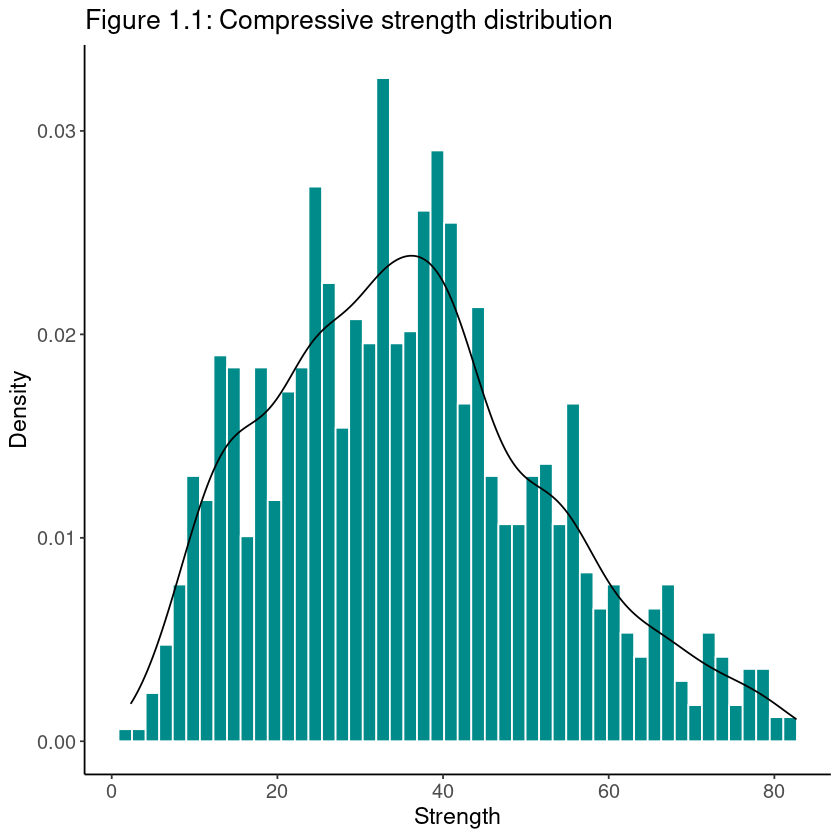

In [9]:
# check to see if the outcome variable is normally distributed
ggplot(df, aes(strength)) +
    geom_histogram(aes(y = ..density..), fill = "dark cyan", col = "white", bins = 50) +
    geom_density(col = "black") +
    labs(x = "Strength", 
         y = "Density", 
         title = "Figure 1.1: Compressive strength distribution") +
    theme_report()

Compressive strength appears to be approximately normally distributed. There is an slight right skew to the distribution, but this can probably be safely ignored.

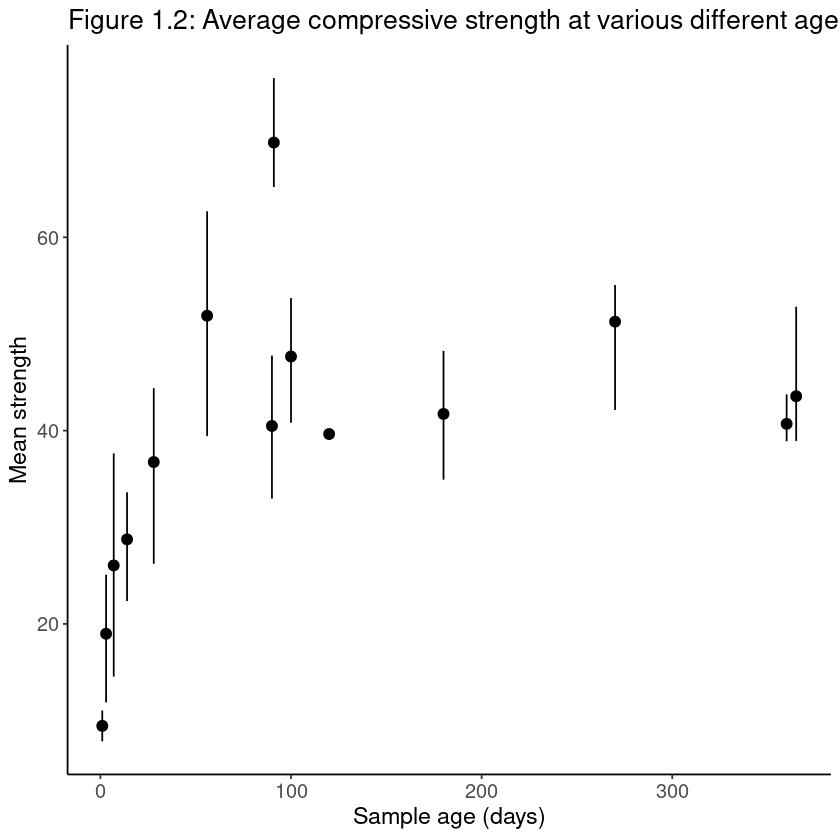

In [10]:
# check the actual average compressive strength of the samples at 1, 7, 14, and 28 days
avg_strength_by_age <- df %>% 
    group_by(age) %>% 
    summarise_at(vars(strength), list(n = length, mean = mean, sd = sd, median = median, iqr = IQR, q1 = ~quantile(., probs = 0.25), q3 = ~quantile(., probs = 0.75)))

avg_strength_by_age %>%
    ggplot(aes(x = age, y = mean)) +
    geom_pointrange(aes(ymin = q1, ymax = q3)) +
    labs(x = "Sample age (days)",
         y = "Mean strength",
         title = "Figure 1.2: Average compressive strength at various different ages") + 
    theme_report()

Compressive strength appears to peak at 91 days of age, before stabilising at a lower value thereafter (the data stopped at 365 days). That being said, these results do have to be taken with a little bit of caution as the number of samples at older ages (>= 120 days) drops off dramatically.

In [11]:
print("Table 1.1: Compressive strength summary statistics at 1, 7, 14 and 28 days")
avg_strength_by_age %>% filter(age %in% c(1, 7, 14, 28))

[1] "Table 1.1: Compressive strength summary statistics at 1, 7, 14 and 28 days"


age n   mean      sd        median    iqr       q1        q3      
1  1    2  9.452716  4.504806  9.452716  3.185379  7.860026 11.04541
2  7  126 26.050623 14.583168 21.650236 23.097446 14.553115 37.65056
3 14   62 28.751038  8.638231 26.541379 11.243630 22.371773 33.61540
4 28  425 36.748480 14.711211 33.762261 18.160798 26.227667 44.38846

In [12]:
# check scatterplots of each explanatory variable against the dependent variable
explanatory_var_labels <- c("Portland cement (kg/m3)", 
                            "Blast furnace slag (kg/m3)", 
                            "Fly ash (kg/m3)",
                            "Water (liters/m3)",
                            "Superplasticiser additive (kg/m3)",
                            "Coarse aggregate (gravel) (kg/m3)",
                            "Fine aggregate (sand) (kg/m3)",
                            "Age (days)")
# explanatory_var_title_labels <- c("Portland cement", 
#                                   "blast furnace slag", 
#                                   "fly ash",
#                                   "water",
#                                   "superplasticiser additive",
#                                   "gravel",
#                                   "sand",
#                                   "sample age")
dependent_var_label <- "Strength (MPa)"

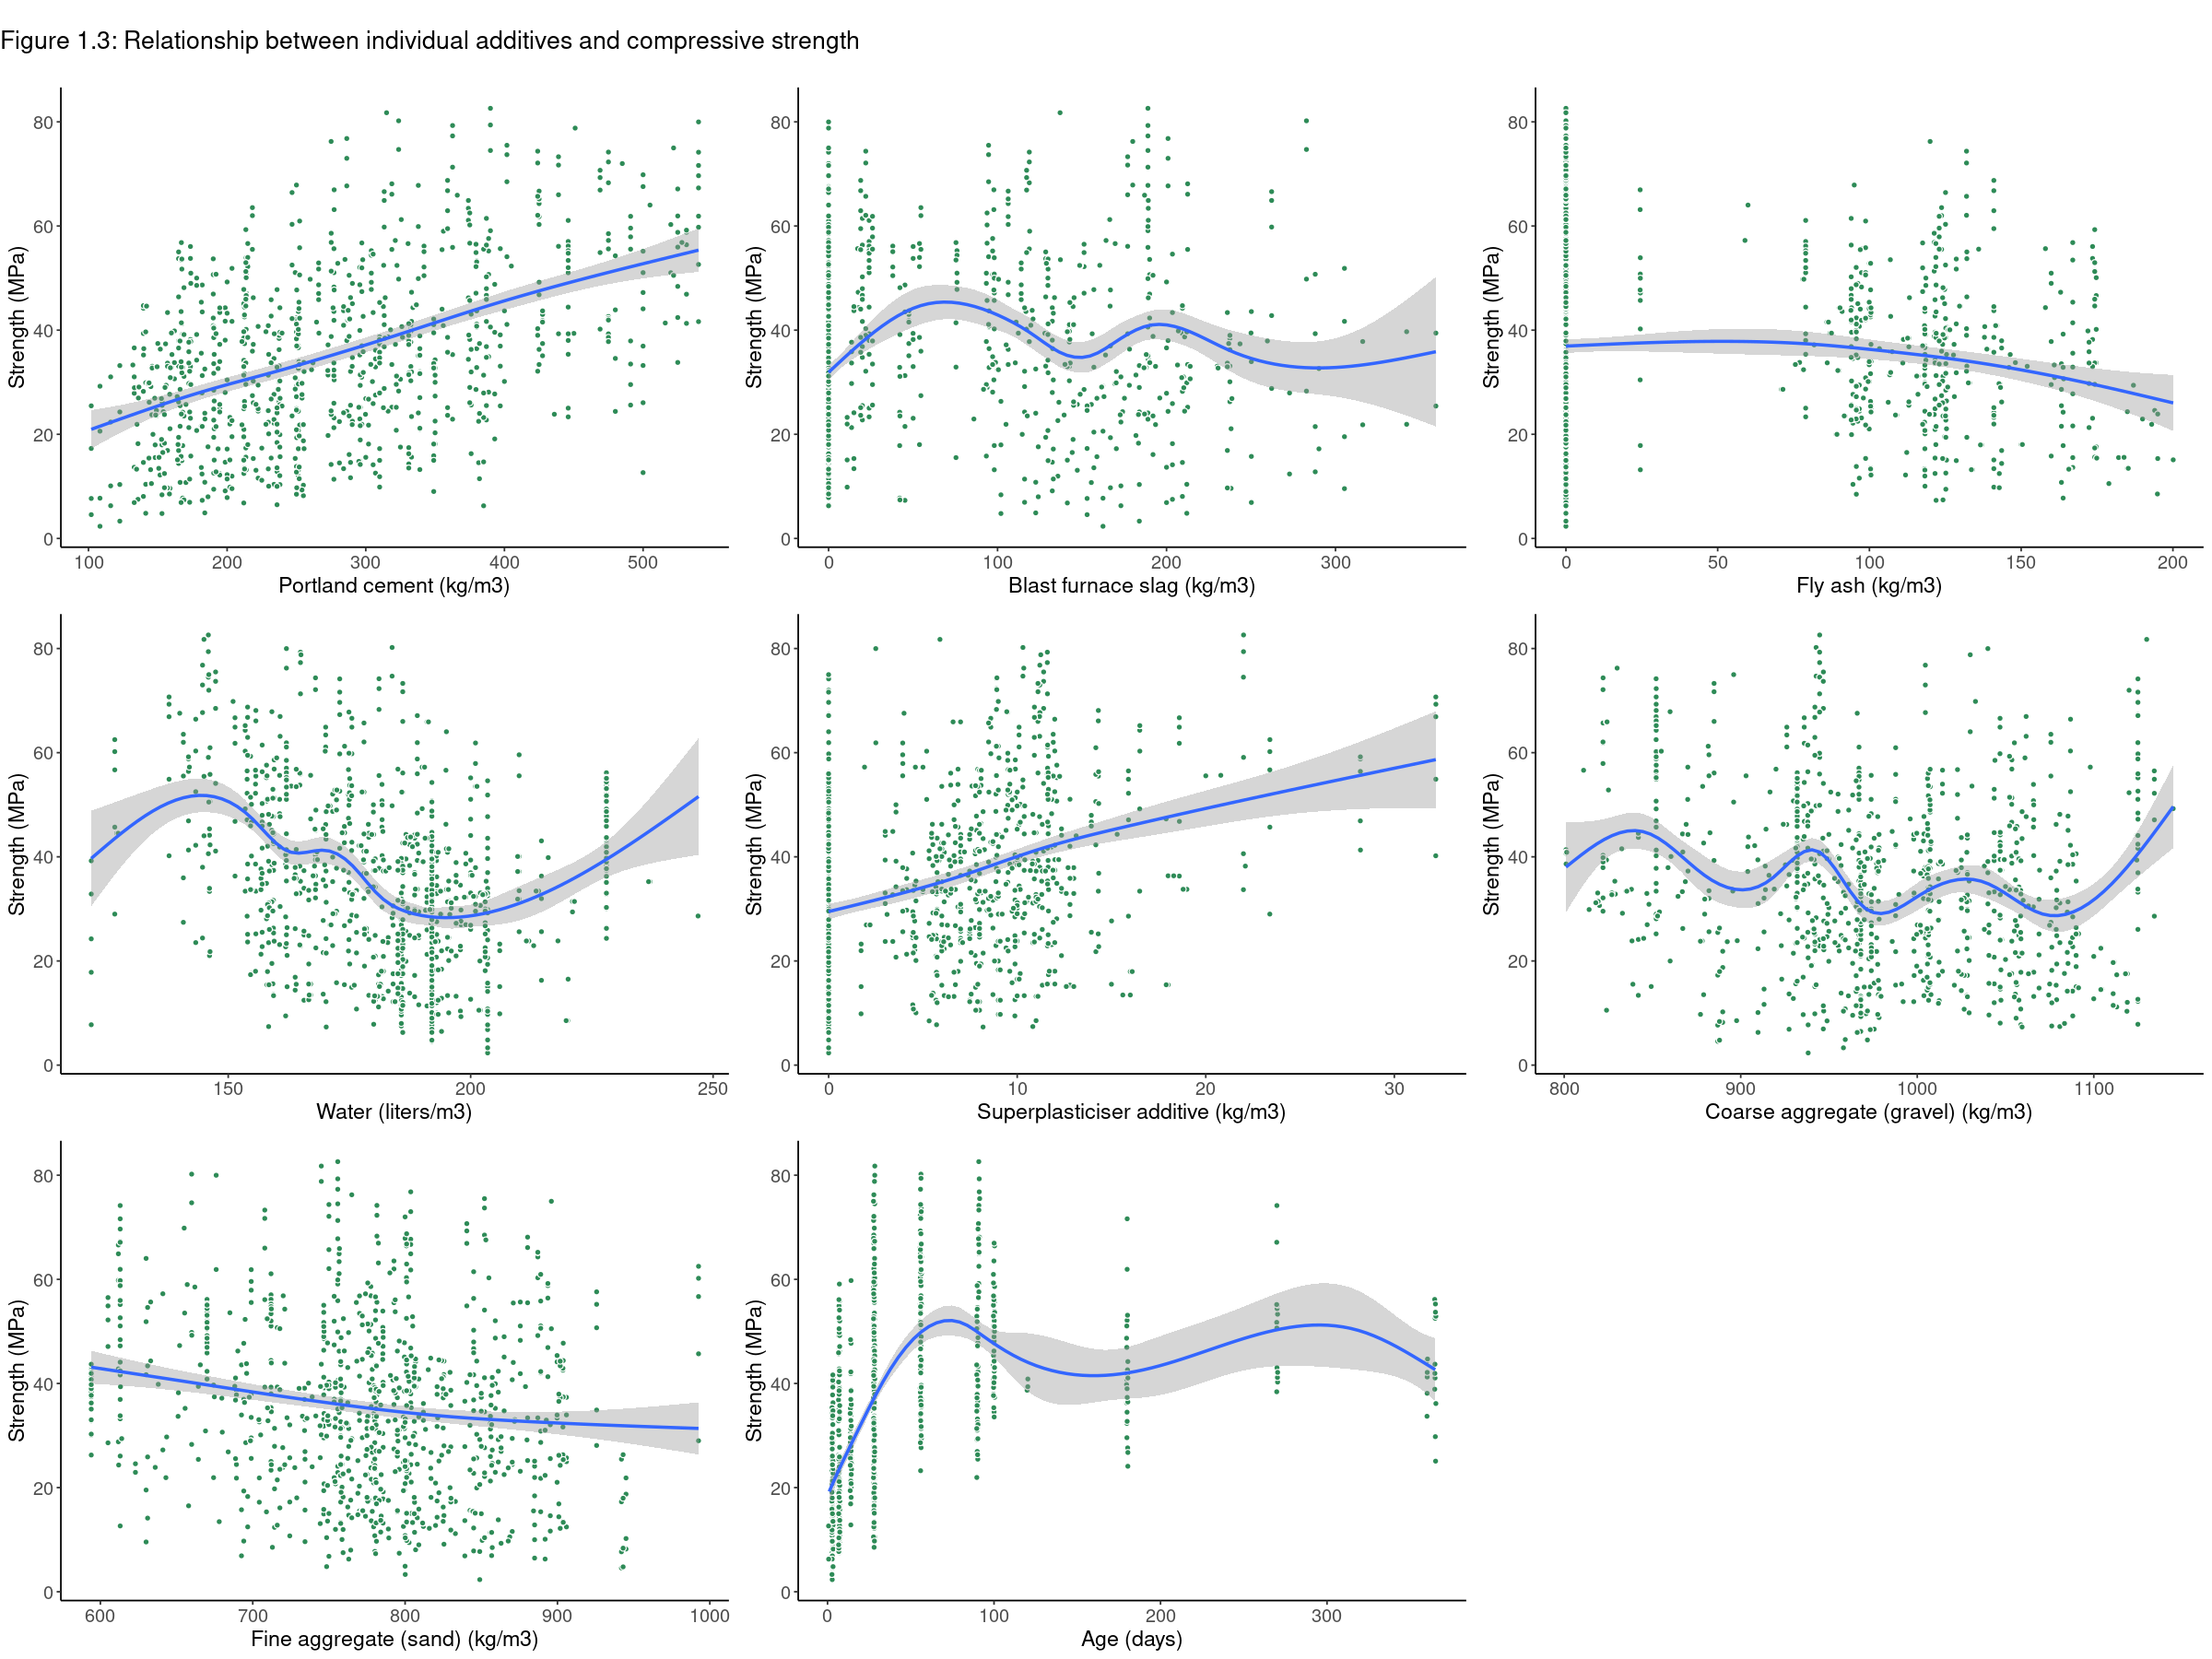

In [13]:
# plot one by one
# i <- 1
# for (col in 1:(ncol(df)-1)) {
#     evar <- colnames(df)[col]
#     ggpl <- ggplot(df, aes(x = .data[[evar]], y = strength)) +
#     geom_jitter(shape = 21, fill = "seagreen", colour = "white") +
#     stat_smooth(formula = y ~ s(x, bs = "cs"), method = "gam") +
#     labs(x = explanatory_var_labels[i], 
#          y = dependent_var_label,
#          title = paste0("Figure 1.3.", i, ": Relationship between ", explanatory_var_title_labels[i], " and compressive strength")) +
#     theme_report()
    
#     print(ggpl)
#     i <- i + 1
# }

# plot in a grid
nums <- seq(1, ncol(df)-1, 1)
pltnames <- paste0("p", nums)
evars <- colnames(df)[nums]

evar_scplot <- function(evar, i) {
    ggplot(df, aes(x = .data[[evar]], y = strength)) +
    geom_jitter(shape = 21, fill = "seagreen", colour = "white") +
    stat_smooth(formula = y ~ s(x, bs = "cs"), method = "gam") +
    labs(y = dependent_var_label,
         x = explanatory_var_labels[i]) +
    theme_report()
    }

plot_list <- map2(evars, nums, evar_scplot)

options(repr.plot.width=20, repr.plot.height=15)
plot_row <- ggarrange(plotlist = plot_list)
title <- ggdraw() + draw_label("Figure 1.3: Relationship between individual additives and compressive strength", x = 0, hjust = 0, size = 16)
plot_grid(title, plot_row, ncol = 1, rel_heights = c(0.05, 1))

It appears as though there is a mix of linear (albeit not strongly linear), monotonic and non-linear relationships between the variables. Furthermore, it appears that there a many instances in which superplasticiser, fly ash and blast furnace slag are not used as concrete additives. As such, we will look at the correlations using both Pearson's and Spearman's correlation because Pearson's correlation only picks up linear relationships and Spearman's correlation picks up monotonic relationships. Furthermore, Spearman's correlation is more robust to outliers than Pearson's (not that we have determined if there are any present in this dataset as yet).

[1] "Figure 1.4.1: Spearman correlation matrix"

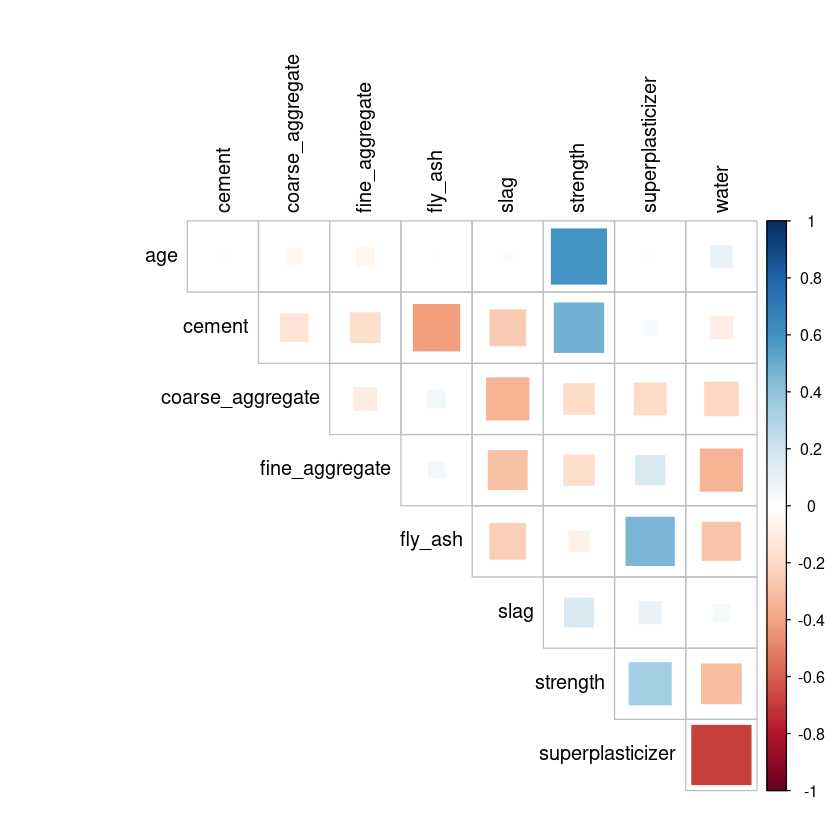

In [14]:
# correlation matrices
options(repr.plot.width=NULL, repr.plot.height=NULL)
"Figure 1.4.1: Spearman correlation matrix"
corr_mat_s <- round(cor(df, method = "spearman"), 4)
corrplot(corr_mat_s, method = 'square', order = "alphabet", type = "upper", diag = FALSE, tl.col = "black", tl.cex = 1.0)

[1] "Figure 1.4.2: Pearson correlation matrix"

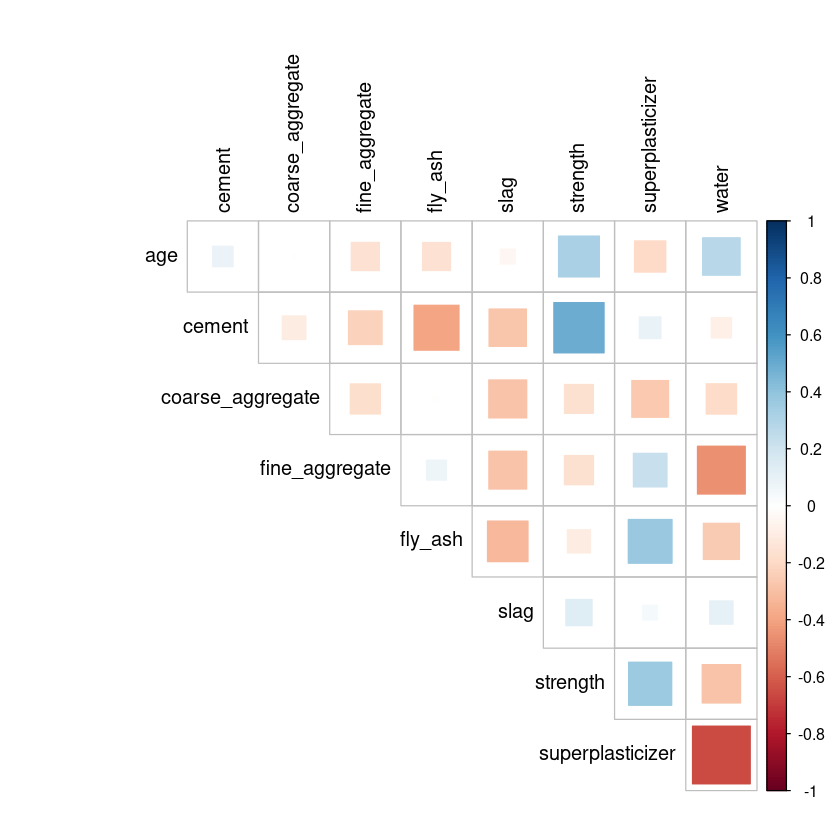

In [15]:
"Figure 1.4.2: Pearson correlation matrix"
corr_mat_p <- round(cor(df, method = "pearson"), 4)
corrplot(corr_mat_p, method = 'square', order = "alphabet", diag = FALSE, type = "upper", tl.col = "black", tl.cex = 1.0)

In [16]:
# corr_mat_p %>% 
#     as.data.frame() %>% 
#     mutate(col_var = rownames(.)) %>% 
#     pivot_longer(!col_var, names_to = "row_var", values_to = "correlation") %>%
#     filter(correlation != 1) %>%
#     filter(abs(correlation) > 0.65) %>%
#     arrange(desc(abs(correlation)))

From the two correlation matrices above, we can confirm that:
- compressive strength is most correlated with cement, age, superplasticiser and water, and
- there is a *moderate negative* relationship between water and superplasticiser[^1]

Hence, we can also conclude that multicollinearity between the explanatory variables is probably not a serious issue, although the relationship between superplasticiser and water is borderline at a value of -0.66.

-----

[^1]: There were no other correlations with an absolute value greater than 0.5.

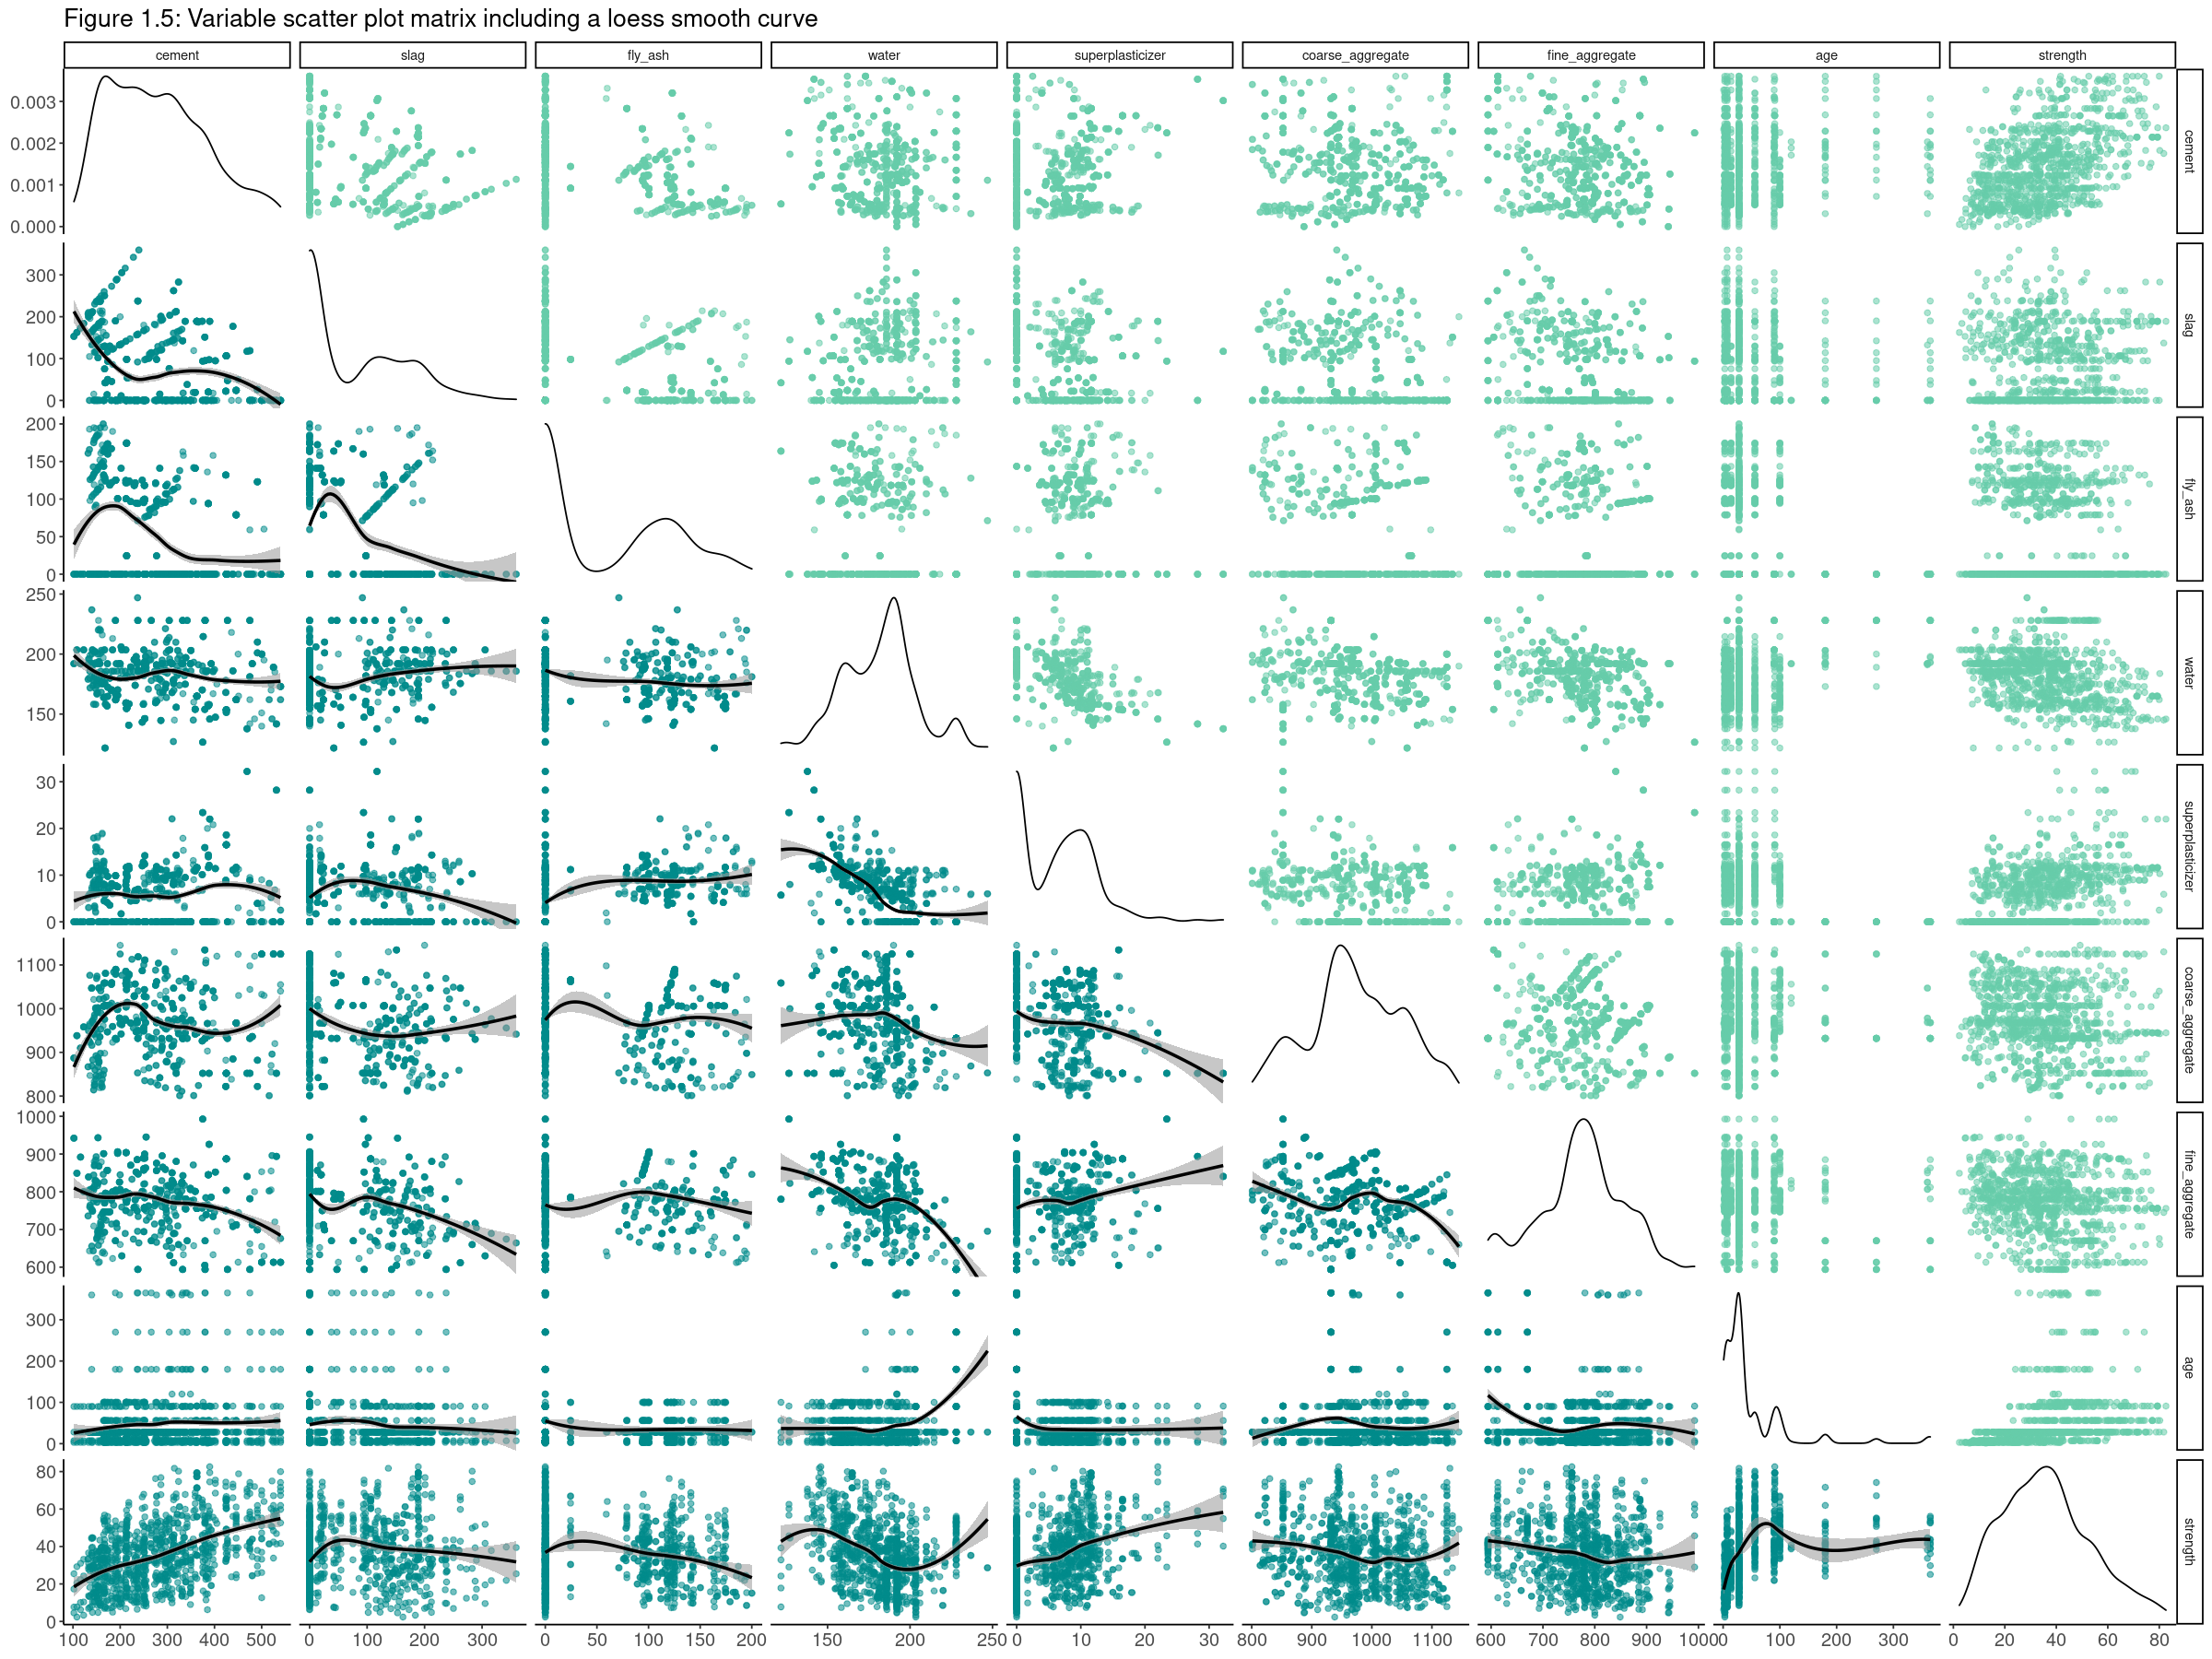

In [17]:
# scatter plot matrix
options(repr.plot.width=20, repr.plot.height=15)
w_ggally_points <- wrap(ggally_points, colour = "seagreen")

ggpairs(df, aes(alpha = 0.5),
        lower = list(continuous = wrap(ggally_smooth_loess, colour = "darkcyan")),
        upper = list(continuous = wrap(ggally_points, colour = "aquamarine3"))) +
labs(title = "Figure 1.5: Variable scatter plot matrix including a loess smooth curve") +
theme_report()

Here, it is fairly clear that there are no strong linear or non-linear relationships between the variables. There are indications of moderate/weak relationships present, especially if the zero values in additives such as slag, fly ash and superplasticiser are ignored.

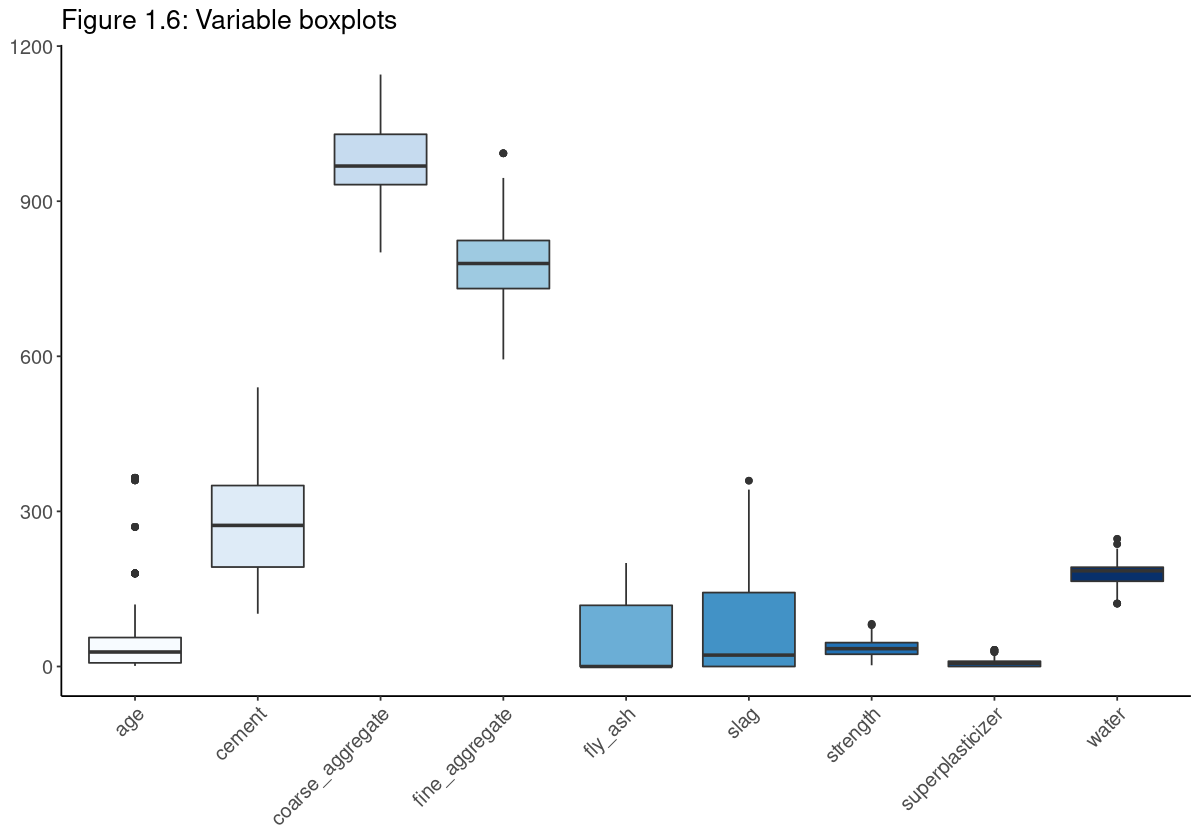

In [18]:
# take a look at the individual distributions of each explanatory variable's values
# in particular, looking for outliers
options(repr.plot.width=10, repr.plot.height=NULL)
df %>%
    pivot_longer(cols = everything(), names_to = "variable") %>%
    ggplot(aes(x = variable, y = value, fill = variable)) +
    geom_boxplot(show.legend = FALSE) +
    labs(x = NULL,
         y = NULL,
         title = "Figure 1.6: Variable boxplots") +
    scale_fill_brewer() +
    theme_report() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))

There are a handful of outliers in all variables except *cement*, *coarse aggregate* and *fly ash*. However, in the case of *slag* and *superplasticiser*, we have to be a little careful and not perform a naive replacement as a zero value means the absence of the additive in the mix and could be important to the modelling process. 

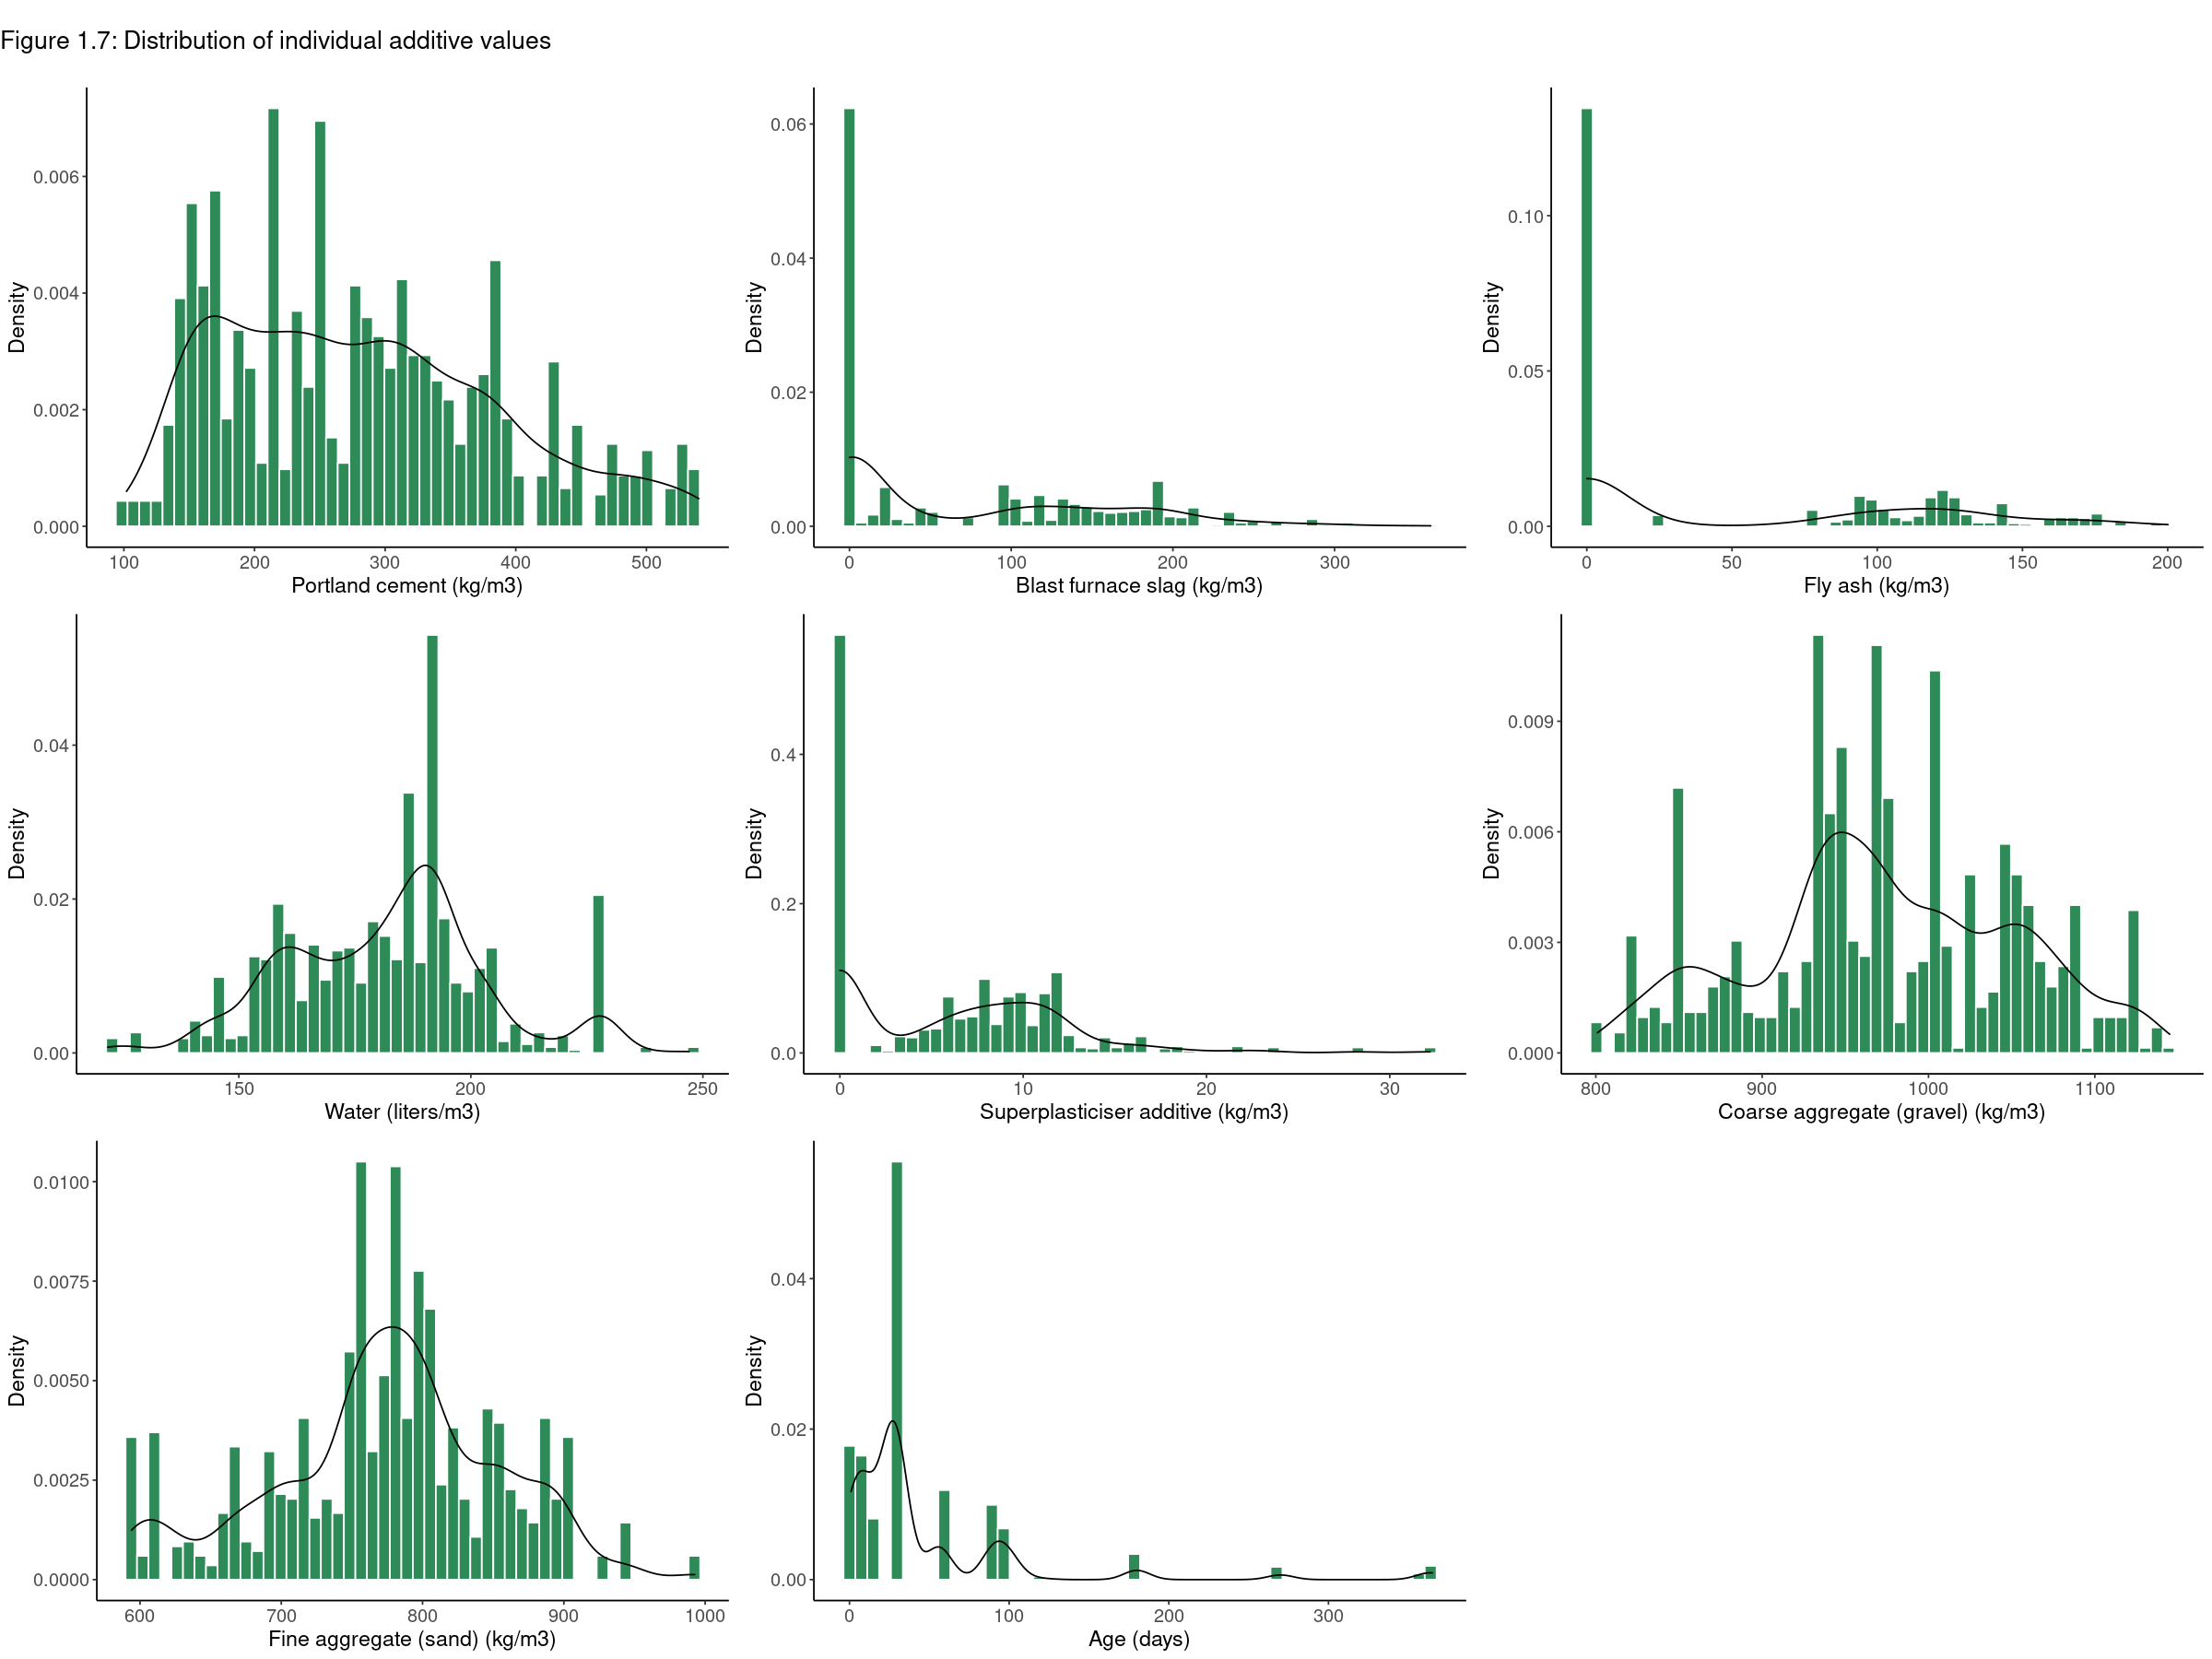

In [19]:
# reset the plot sizes to their default values
options(repr.plot.width=NULL, repr.plot.height=NULL)

# plot one by one
# i <- 1
# for (col in 1:(ncol(df)-1)) {
#     evar <- colnames(df)[col]
#     ggpl <- ggplot(df, aes(.data[[evar]])) +
#     geom_histogram(aes(y = ..density..), bins = 50, fill = "seagreen", colour = "white") +
#     geom_density(col = "black") +
#     labs(x = explanatory_var_labels[i], 
#          y = "Density",
#          title = paste0("Figure 1.7.", i, ": Distribution of ", explanatory_var_title_labels[i])) +
#     theme_report()
    
#     print(ggpl)
#     i <- i + 1
# }

# plot in a grid
# these are the same as before
# nums <- seq(1, ncol(df)-1, 1)
# pltnames <- paste0("p", nums)
# evars <- colnames(df)[nums]

evar_histplot <- function(evar, i) {
    ggplot(df, aes(.data[[evar]])) +
    geom_histogram(aes(y = ..density..), bins = 50, fill = "seagreen", colour = "white") +
    geom_density(col = "black") +
    labs(y = "Density",
         x = explanatory_var_labels[i]) +
    theme_report()
    }

plot_list <- map2(evars, nums, evar_histplot)

options(repr.plot.width=20, repr.plot.height=15)
plot_row <- ggarrange(plotlist = plot_list)
title <- ggdraw() + draw_label("Figure 1.7: Distribution of individual additive values", x = 0, hjust = 0, size = 16)
plot_grid(title, plot_row, ncol = 1, rel_heights = c(0.05, 1))

## Data Cleaning / Feature Engineering

In [20]:
df_imp <- data.table::copy(df)
df_cap <- data.table::copy(df)

# identify outliers using the IQR method
for (col in colnames(df)) {
    num_outliers <- length(boxplot.stats(df[[col]])$out)
    #paste(col, ":", 
    if (num_outliers > 0 & col != "strength") {
        outlier_values <- boxplot.stats(df[[col]])$out
        quantiles <- quantile(df[[col]], probs = c(0.25, 0.75))
        caps <- quantile(df[[col]], probs = c(0.05, 0.95))
        boundary <- 1.5 * IQR(df[[col]])
        #outlier_inds <- which(df[[col]] %in% c(outlier_values))
        # replace outliers with the variable median (imputation)
        df_imp[[col]][df_imp[[col]] %in% c(outlier_values)] <- median(df[[col]])
        # replace outliers with the value of the 5th/95th percentile (capping)
        df_cap[[col]][df_cap[[col]] < (quantiles[1] - boundary)] <- caps[1]
        df_cap[[col]][df_cap[[col]] > (quantiles[2] + boundary)] <- caps[2]
    }
}

In [21]:
# function to create the additional explanatory variables based on the work of Yeh (1998)
createAdditionalVars <- function(input_df) {
    additional_vars <- data.frame(matrix(nrow = 1030, ncol = 8)) %>%
        mutate(binder = input_df$cement + input_df$slag + input_df$fly_ash,
               water_to_cement = input_df$water / input_df$cement,
               water_to_binder = input_df$water / binder,
               superplasticiser_to_binder = input_df$superplasticizer / binder,
               fly_ash_to_binder = input_df$fly_ash / binder,
               slag_to_binder = input_df$slag / binder,
               fly_ash_slag_to_binder = (input_df$fly_ash + input_df$slag) / binder,
               strength = input_df$strength) %>%
        select(-c(X1:X8))
    return(additional_vars)
    }

In [22]:
# apply the function to the three dataframes
additional_vars <- createAdditionalVars(df)
additional_vars_imp <- createAdditionalVars(df_imp)
additional_vars_cap <- createAdditionalVars(df_cap)

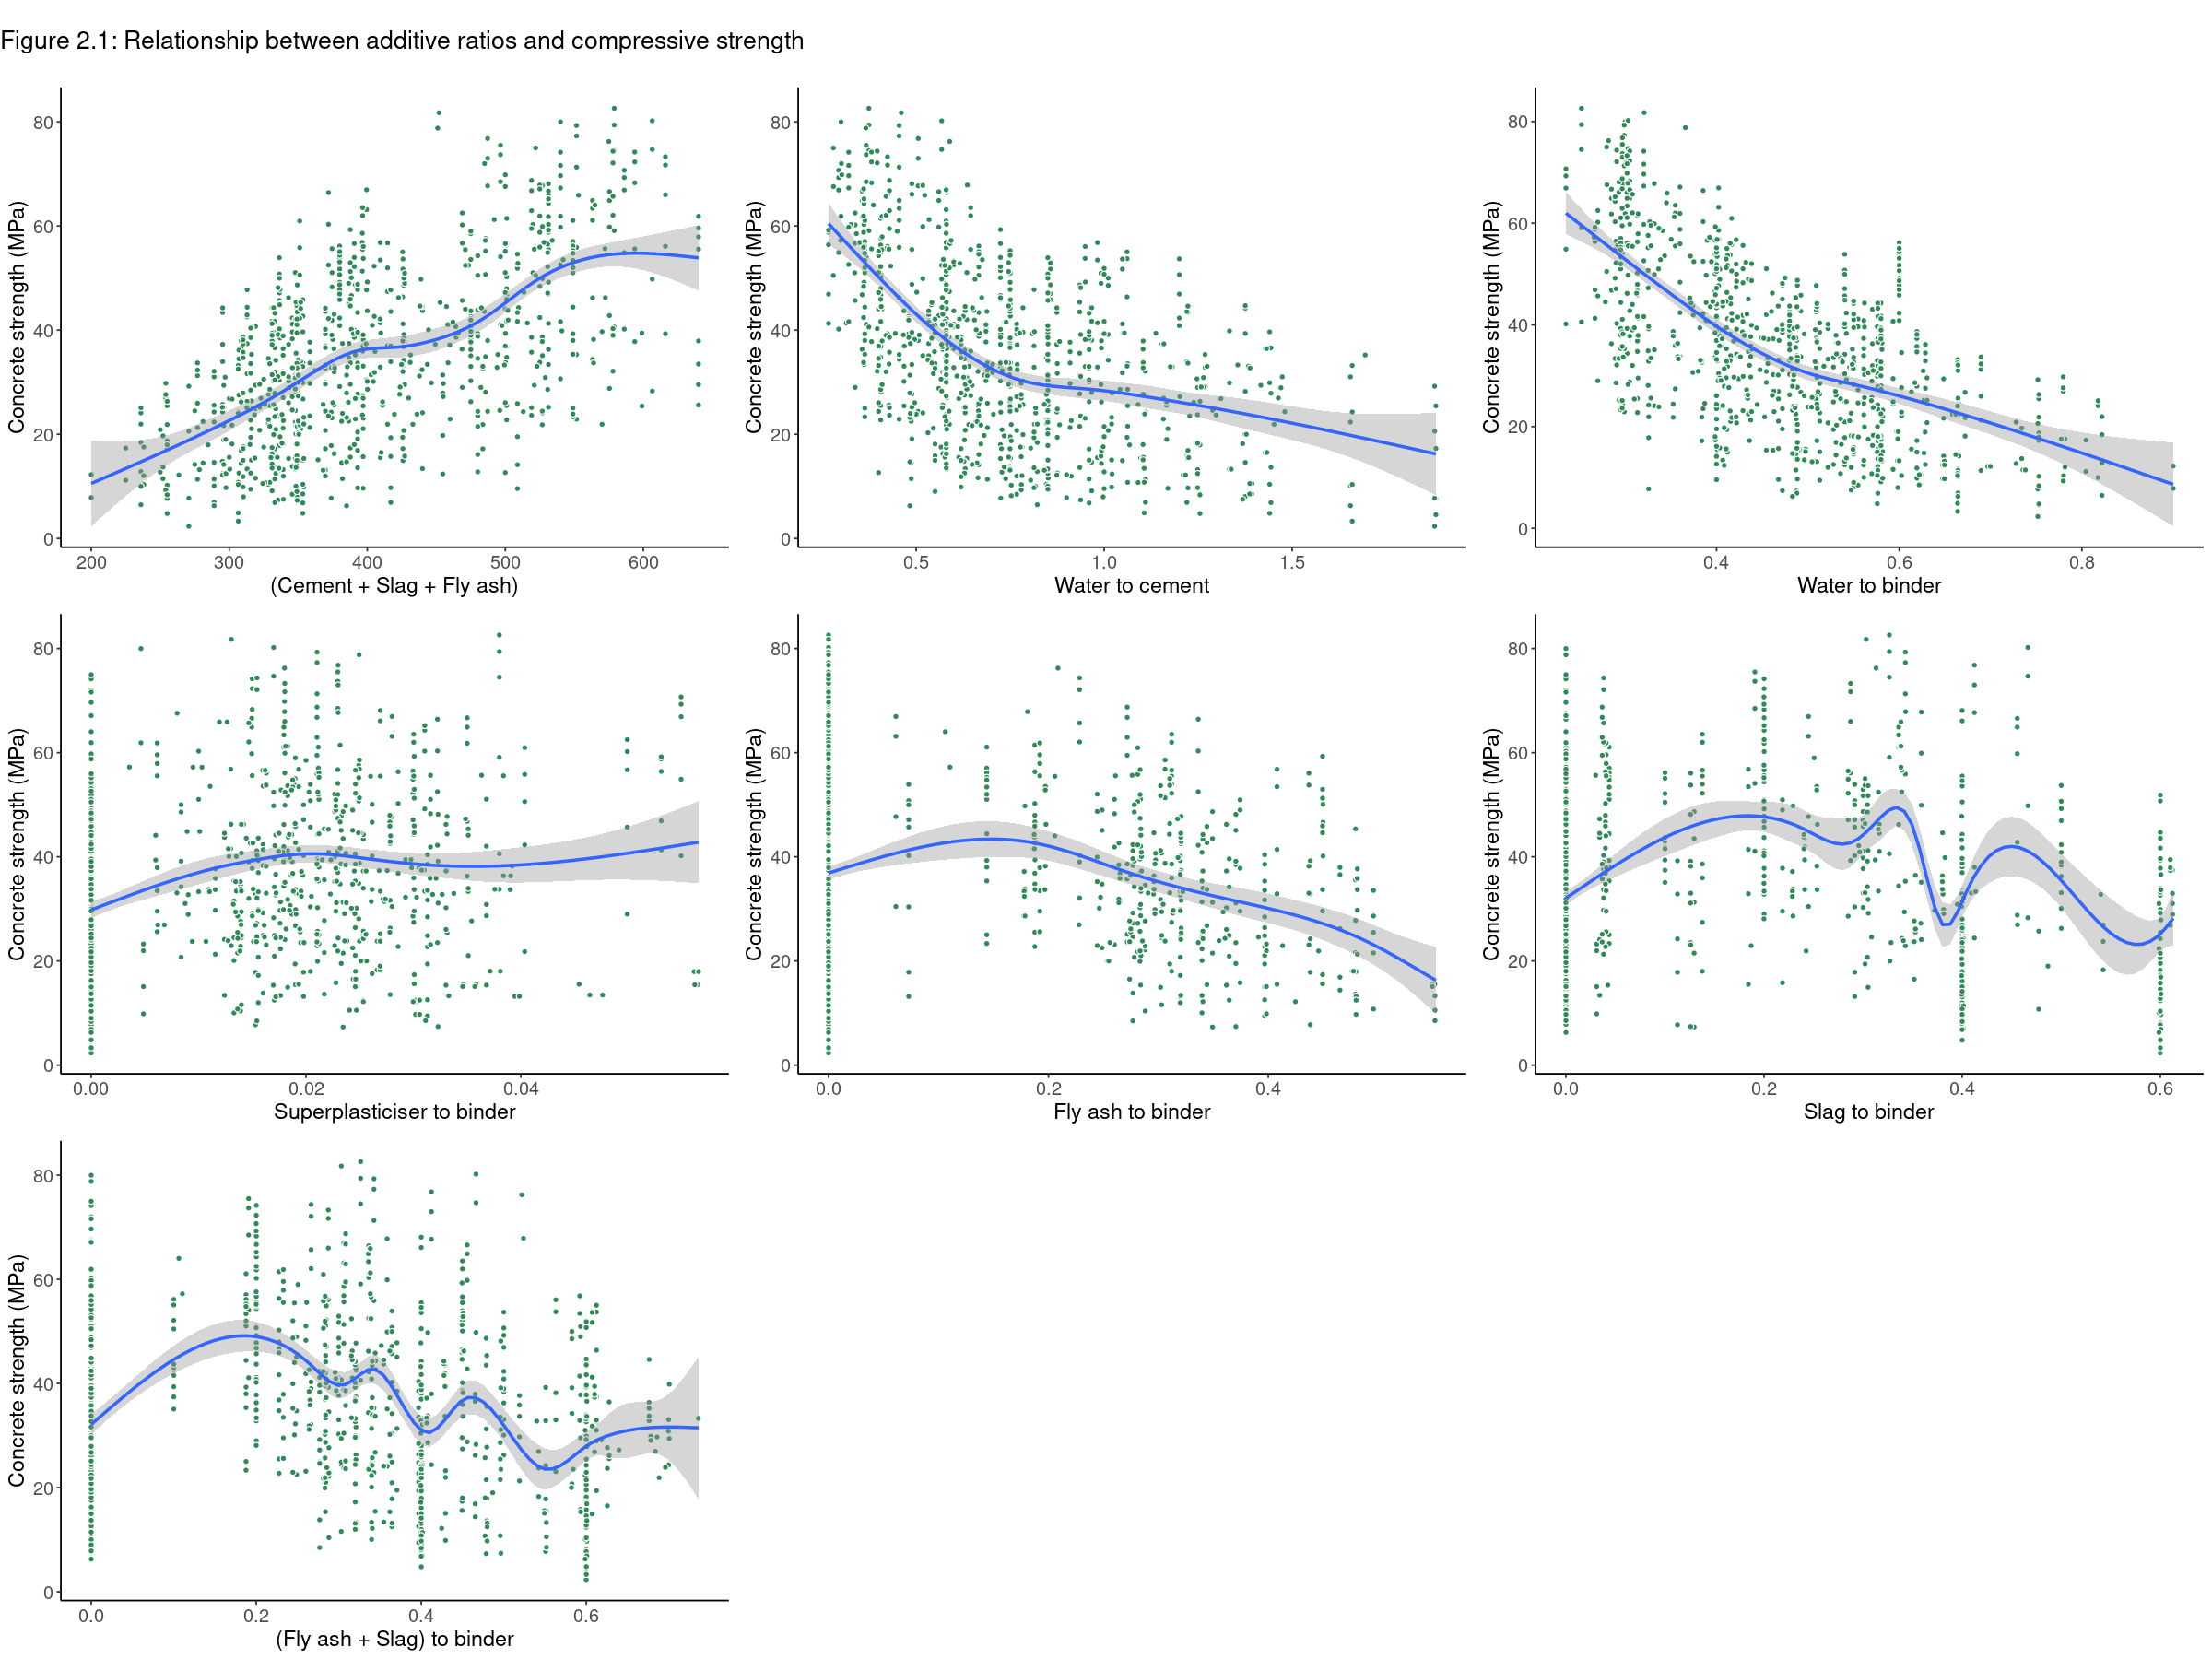

In [23]:
# visualise their relationship with compressive strength
explanatory_var_labels <- c("(Cement + Slag + Fly ash)", 
                            "Water to cement", 
                            "Water to binder",
                            "Superplasticiser to binder",
                            "Fly ash to binder",
                            "Slag to binder",
                            "(Fly ash + Slag) to binder")
# explanatory_var_title_labels <- c("binder", 
#                                   "water to cement ratio", 
#                                   "water to binder ratio",
#                                   "superplasticiser to binder ratio",
#                                   "fly ash to binder ratio",
#                                   "blast furnace slag to binder ratio",
#                                   "(fly ash plus blast furnace slag) to binder ratio")
dependent_var_label <- "Concrete strength (MPa)"

# plot one by one
# i <- 1
# for (col in 1:(ncol(additional_vars)-1)) {
#     evar <- colnames(additional_vars)[col]
#     ggpl <- ggplot(additional_vars, aes(x = .data[[evar]], y = strength)) +
#     geom_jitter(shape = 21, fill = "seagreen", colour = "white") +
#     stat_smooth(formula = y ~ s(x, bs = "cs"), method = "gam") +
#     labs(x = explanatory_var_labels[i], 
#          y = dependent_var_label,
#          title = paste0("Figure 2.1.", i, ": Relationship between the ", explanatory_var_title_labels[i], " and compressive strength")) +
#     theme_report()
    
#     print(ggpl)
#     i <- i + 1
# }

# plot in a grid
nums <- seq(1, ncol(additional_vars)-1, 1)
pltnames <- paste0("p", nums)
evars <- colnames(additional_vars)[nums]

evar_sc2plot <- function(evar, i) {
    ggplot(additional_vars, aes(x = .data[[evar]], y = strength)) +
    geom_jitter(shape = 21, fill = "seagreen", colour = "white") +
    stat_smooth(formula = y ~ s(x, bs = "cs"), method = "gam") +
    labs(y = dependent_var_label,
         x = explanatory_var_labels[i]) +
    theme_report()
    }

plot_list <- map2(evars, nums, evar_sc2plot)

plot_row <- ggarrange(plotlist = plot_list)
title <- ggdraw() + draw_label("Figure 2.1: Relationship between additive ratios and compressive strength", x = 0, hjust = 0, size = 16)
plot_grid(title, plot_row, ncol = 1, rel_heights = c(0.05, 1))

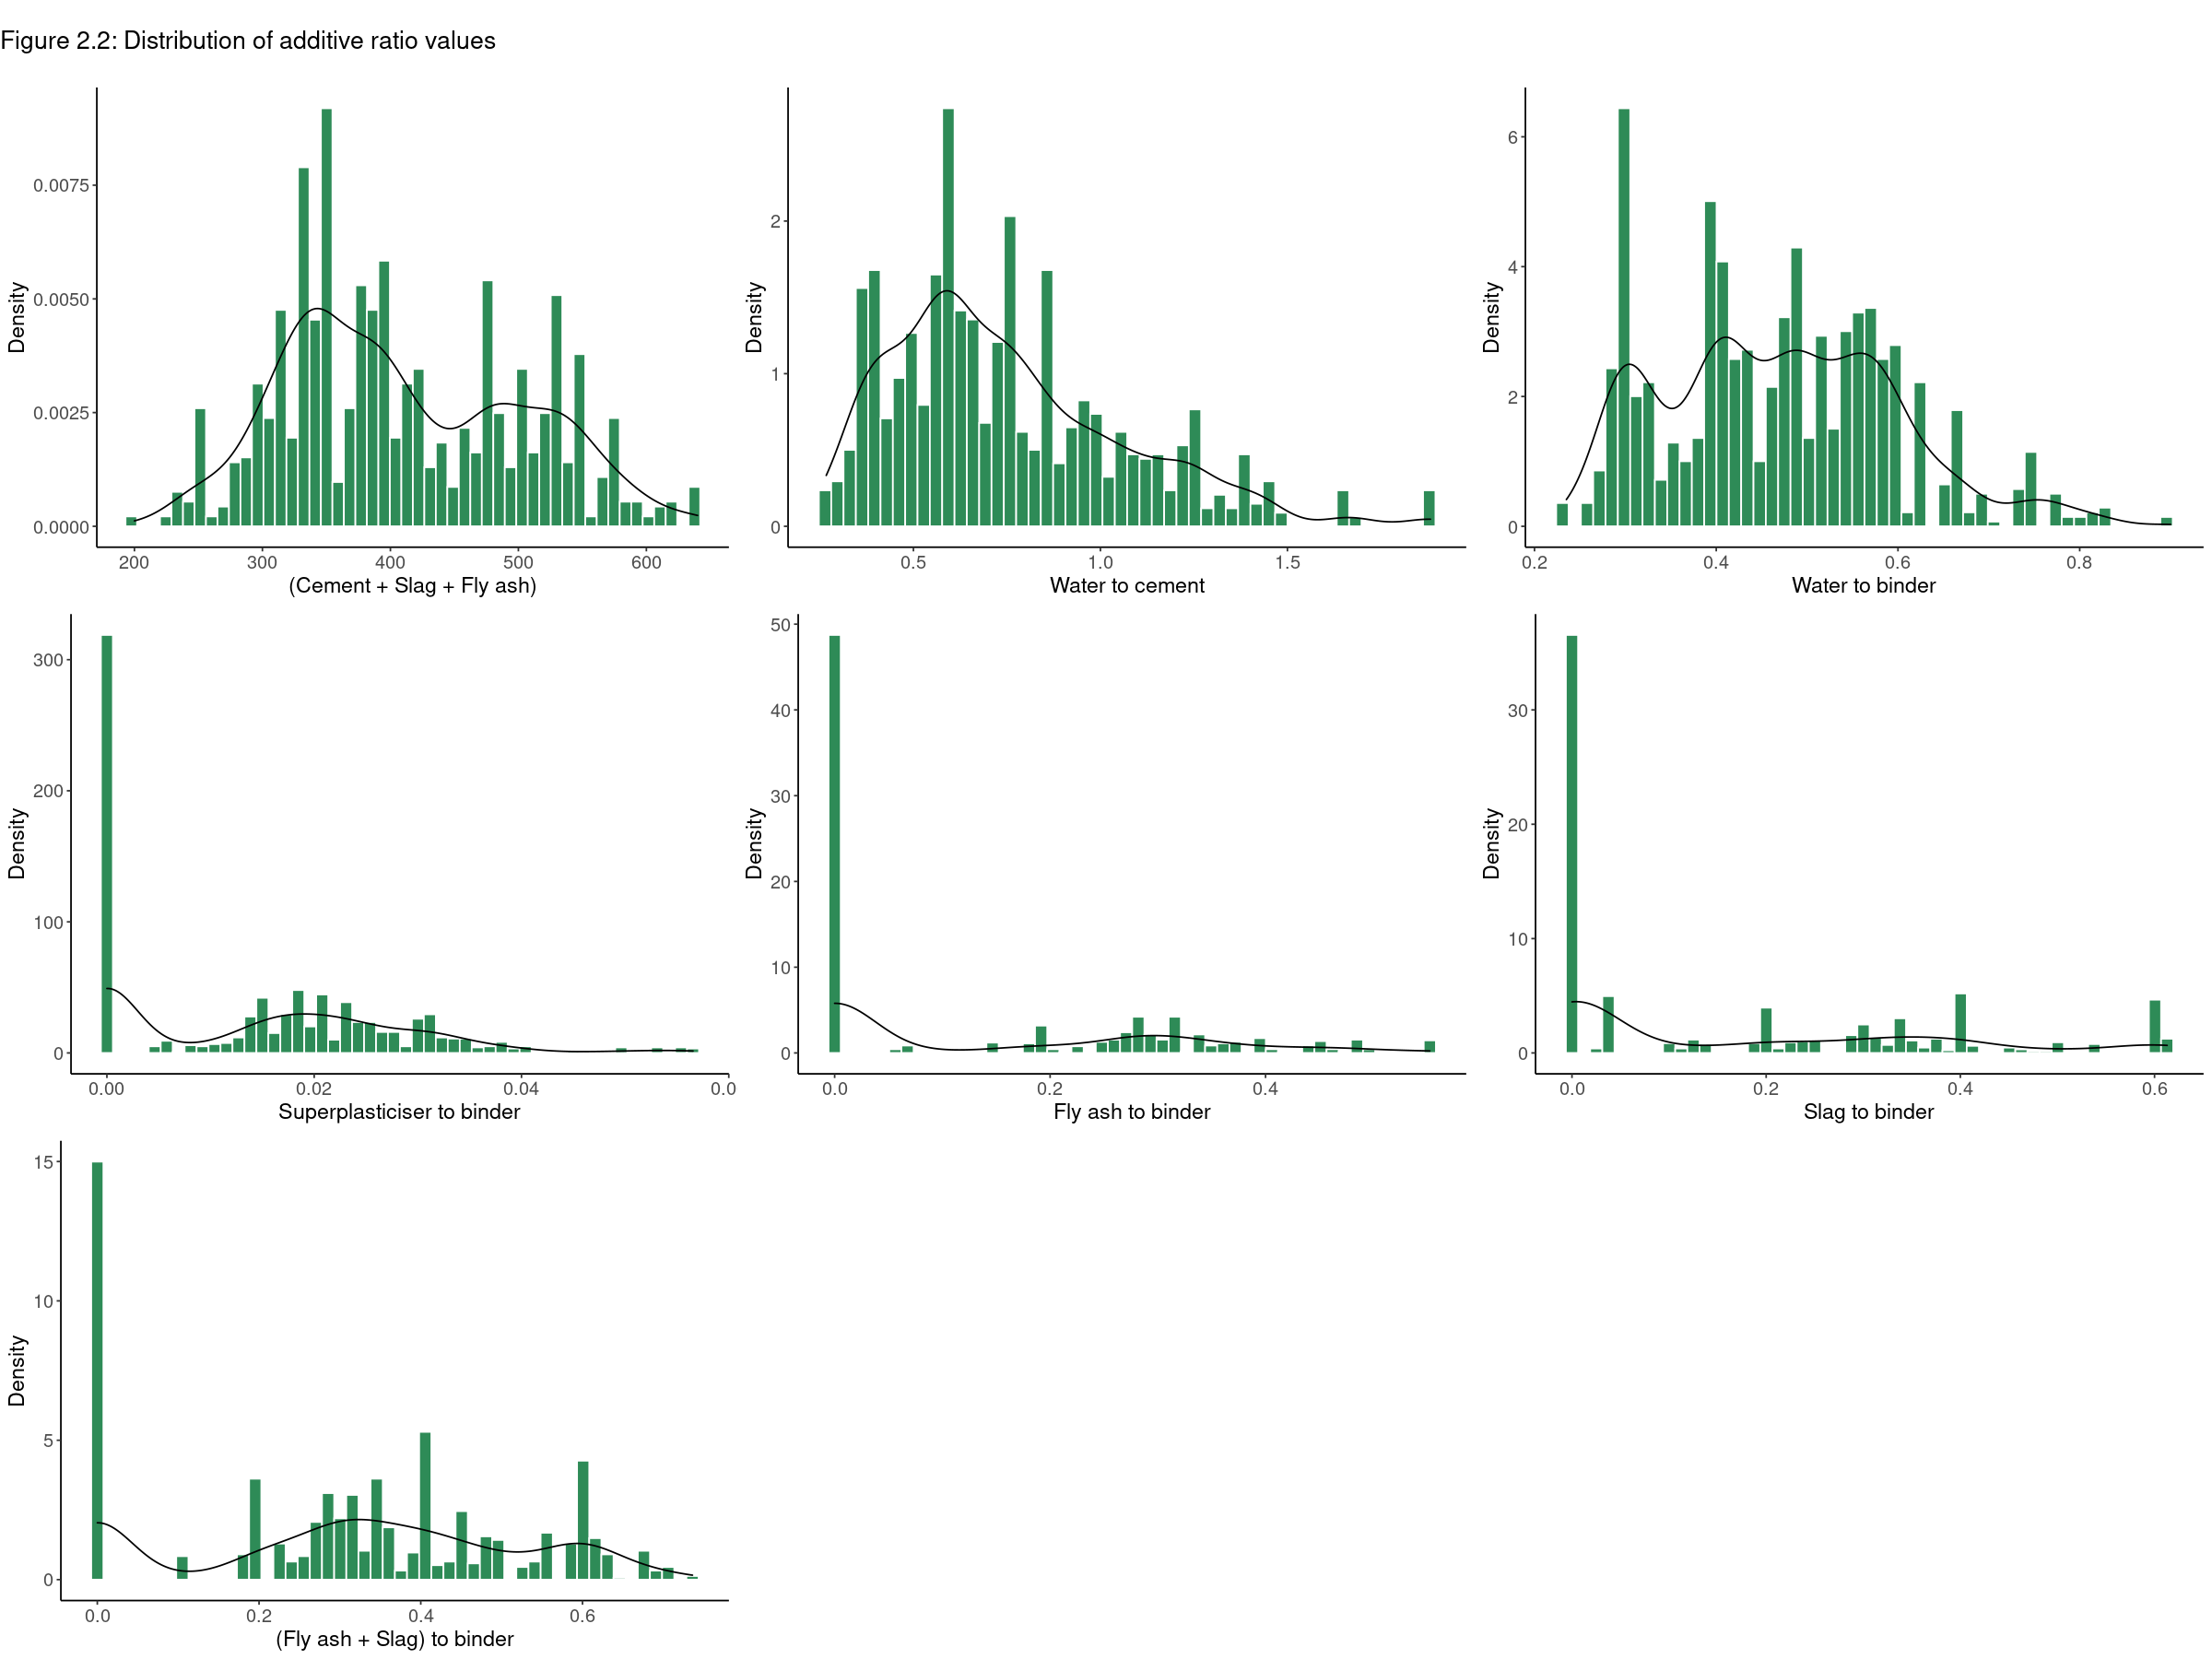

In [24]:
# reset the plot sizes to their default values
options(repr.plot.width=NULL, repr.plot.height=NULL)

# plot one by one
# i <- 1
# for (col in 1:(ncol(additional_vars)-1)) {
#     evar <- colnames(additional_vars)[col]
#     ggpl <- ggplot(additional_vars, aes(.data[[evar]])) +
#     geom_histogram(aes(y = ..density..), bins = 50, fill = "seagreen", colour = "white") +
#     geom_density(col = "black") +
#     labs(x = explanatory_var_labels[i], 
#          y = "Density",
#          title = paste0("Figure 2.2.", i, ": Distribution of ", explanatory_var_title_labels[i])) +
#     theme_report()
    
#     print(ggpl)
#     i <- i + 1
# }

# plot in a grid
# these are the same as before
# nums <- seq(1, ncol(additional_vars)-1, 1)
# pltnames <- paste0("p", nums)
# evars <- colnames(additional_vars)[nums]

evar_histplot2 <- function(evar, i) {
    ggplot(additional_vars, aes(.data[[evar]])) +
    geom_histogram(aes(y = ..density..), bins = 50, fill = "seagreen", colour = "white") +
    geom_density(col = "black") +
    labs(y = "Density",
         x = explanatory_var_labels[i]) +
    theme_report()
    }

plot_list <- map2(evars, nums, evar_histplot2)

options(repr.plot.width=20, repr.plot.height=15)
plot_row <- ggarrange(plotlist = plot_list)
title <- ggdraw() + draw_label("Figure 2.2: Distribution of additive ratio values", x = 0, hjust = 0, size = 16)
plot_grid(title, plot_row, ncol = 1, rel_heights = c(0.05, 1))

New names:
• `strength` -> `strength...9`
• `strength` -> `strength...17`


[1] "Figure 2.3: Pearson correlation matrix"

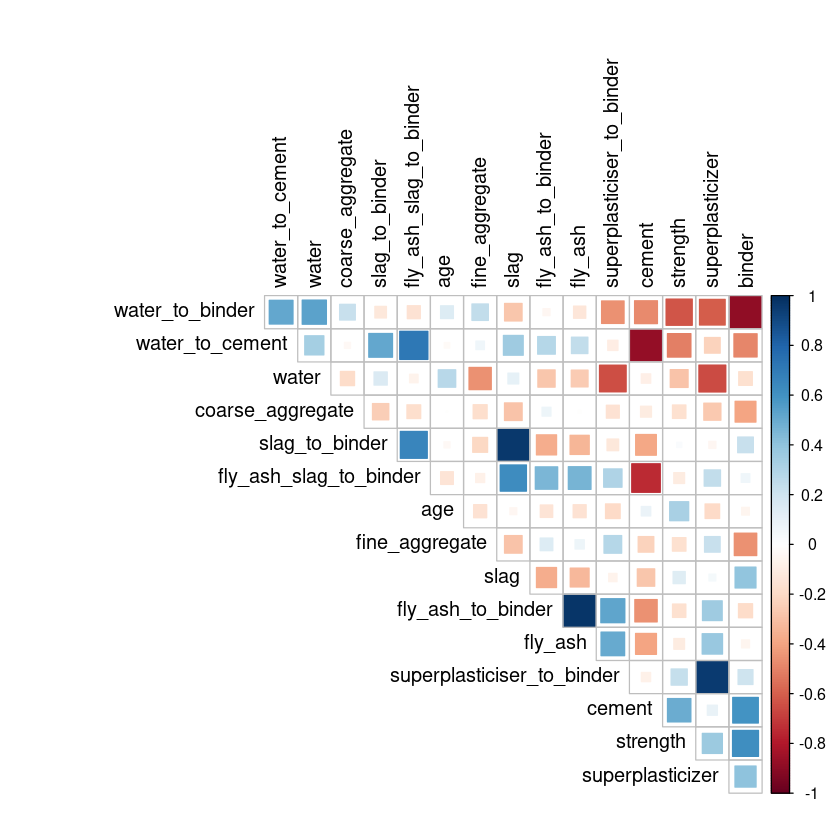

In [25]:
# take another look at the correlations between the features
df_all <- df %>% 
    bind_cols(additional_vars) %>% 
    select(-c(strength...9, strength...17)) %>%
    mutate(strength = df$strength)

options(repr.plot.width=NULL, repr.plot.height=NULL)
"Figure 2.3: Pearson correlation matrix"
corr_mat_p <- round(cor(df_all, method = "pearson"), 4)
corrplot(corr_mat_p, method = 'square', order = "FPC", diag = FALSE, type = "upper", tl.col = "black", tl.cex = 1.0)

In [26]:
# corr_mat_p %>% 
#     as.data.frame() %>% 
#     mutate(col_var = rownames(.)) %>% 
#     pivot_longer(!col_var, names_to = "row_var", values_to = "correlation") %>%
#     filter(correlation != 1) %>%
#     filter(abs(correlation) > 0.65) %>%
#     arrange(desc(abs(correlation)))

There's definitely an opportunity to explore feature reduction with PCA as one of the general rules-of-thumb thresholds is an absolute correlation value greater or equal to 0.7:
- fly ash and fly ash to binder (0.97)
- slag and slag to binder (0.96)
- superplasticiser and superplasticiser to binder (0.95)
- water and water to binder (-0.89)
- cement and water to cement (-0.88)
- cement and fly ash + slag to binder (-0.74)
- water to cement and fly_ash + slag to binder (0.72)
- slag to binder and fly_ash + slag to binder (0.66)
- water to superplasticiser (-0.66)

## Principal Components Analysis (Linear Dimensionality Reduction)

### Initial Dataset

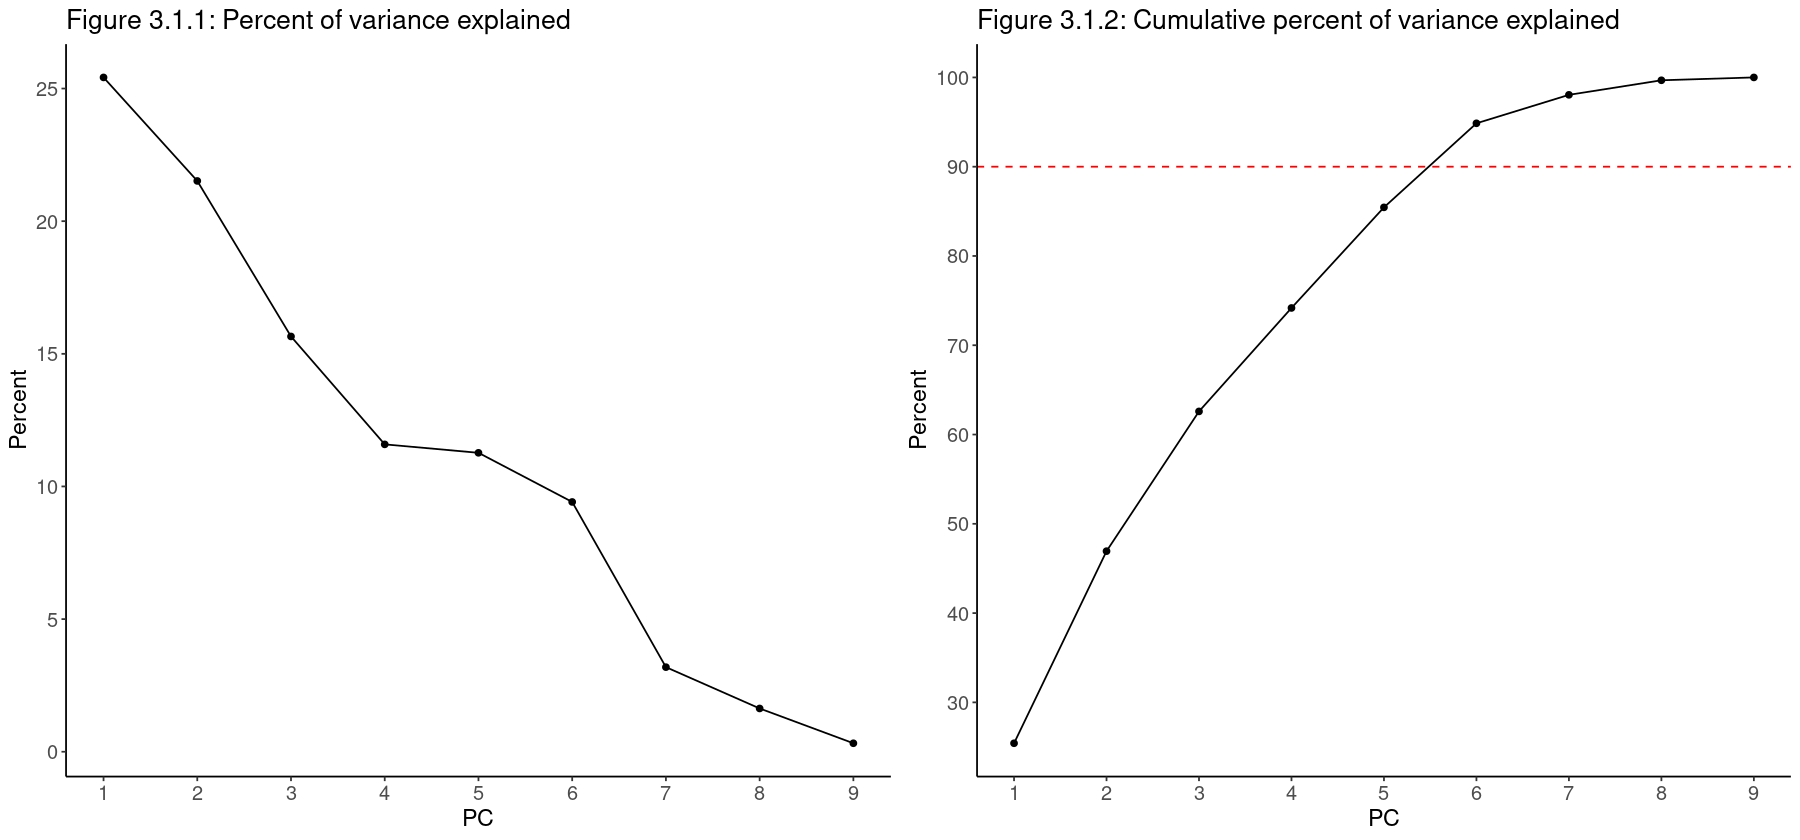

In [27]:
pca1_rec <- recipe(~., data = df)

pca1_trans <- pca1_rec %>%
    step_normalize(all_predictors(), id = "normalise") %>%
    step_pca(all_predictors(), id = "pca", num_comp = 5)

pca1_prep <- prep(pca1_trans)
pca1_loadings = tidy(pca1_prep, id = "pca")
pca1_variance = tidy(pca1_prep, id = "pca", type = "variance") # includes variance, cumulative variance, percent variance and cumulative percent variance

p1 <- pca1_variance %>%
    filter(terms == "percent variance") %>%
    ggplot(aes(x = component, y = value)) +
    geom_line() +
    geom_point() +
    scale_x_continuous(breaks = seq(1, 9, 1)) +
    labs(x = "PC", 
         y = "Percent",
         title = "Figure 3.1.1: Percent of variance explained") +
    theme_report()

p2 <- pca1_variance %>%
    filter(terms == "cumulative percent variance") %>%
    ggplot(aes(x = component, y = value)) +
    geom_line() +
    geom_point() +
    geom_hline(yintercept = 90, col = "red", linetype = "dashed") +
    scale_x_continuous(breaks = seq(1, 9, 1)) +
    scale_y_continuous(breaks = seq(0, 100, 10)) +
    labs(x = "PC", 
         y = "Percent",
         title = "Figure 3.1.2: Cumulative percent of variance explained") +
    theme_report()

options(repr.plot.width=15, repr.plot.height=NULL)
plot_grid(p1, p2, ncol = 2)

There is no distinct elbow in the scree plot (Figure 3.1.1), but the second figure indicates that five principal components is sufficient to capture around 85% of the variation in the data.

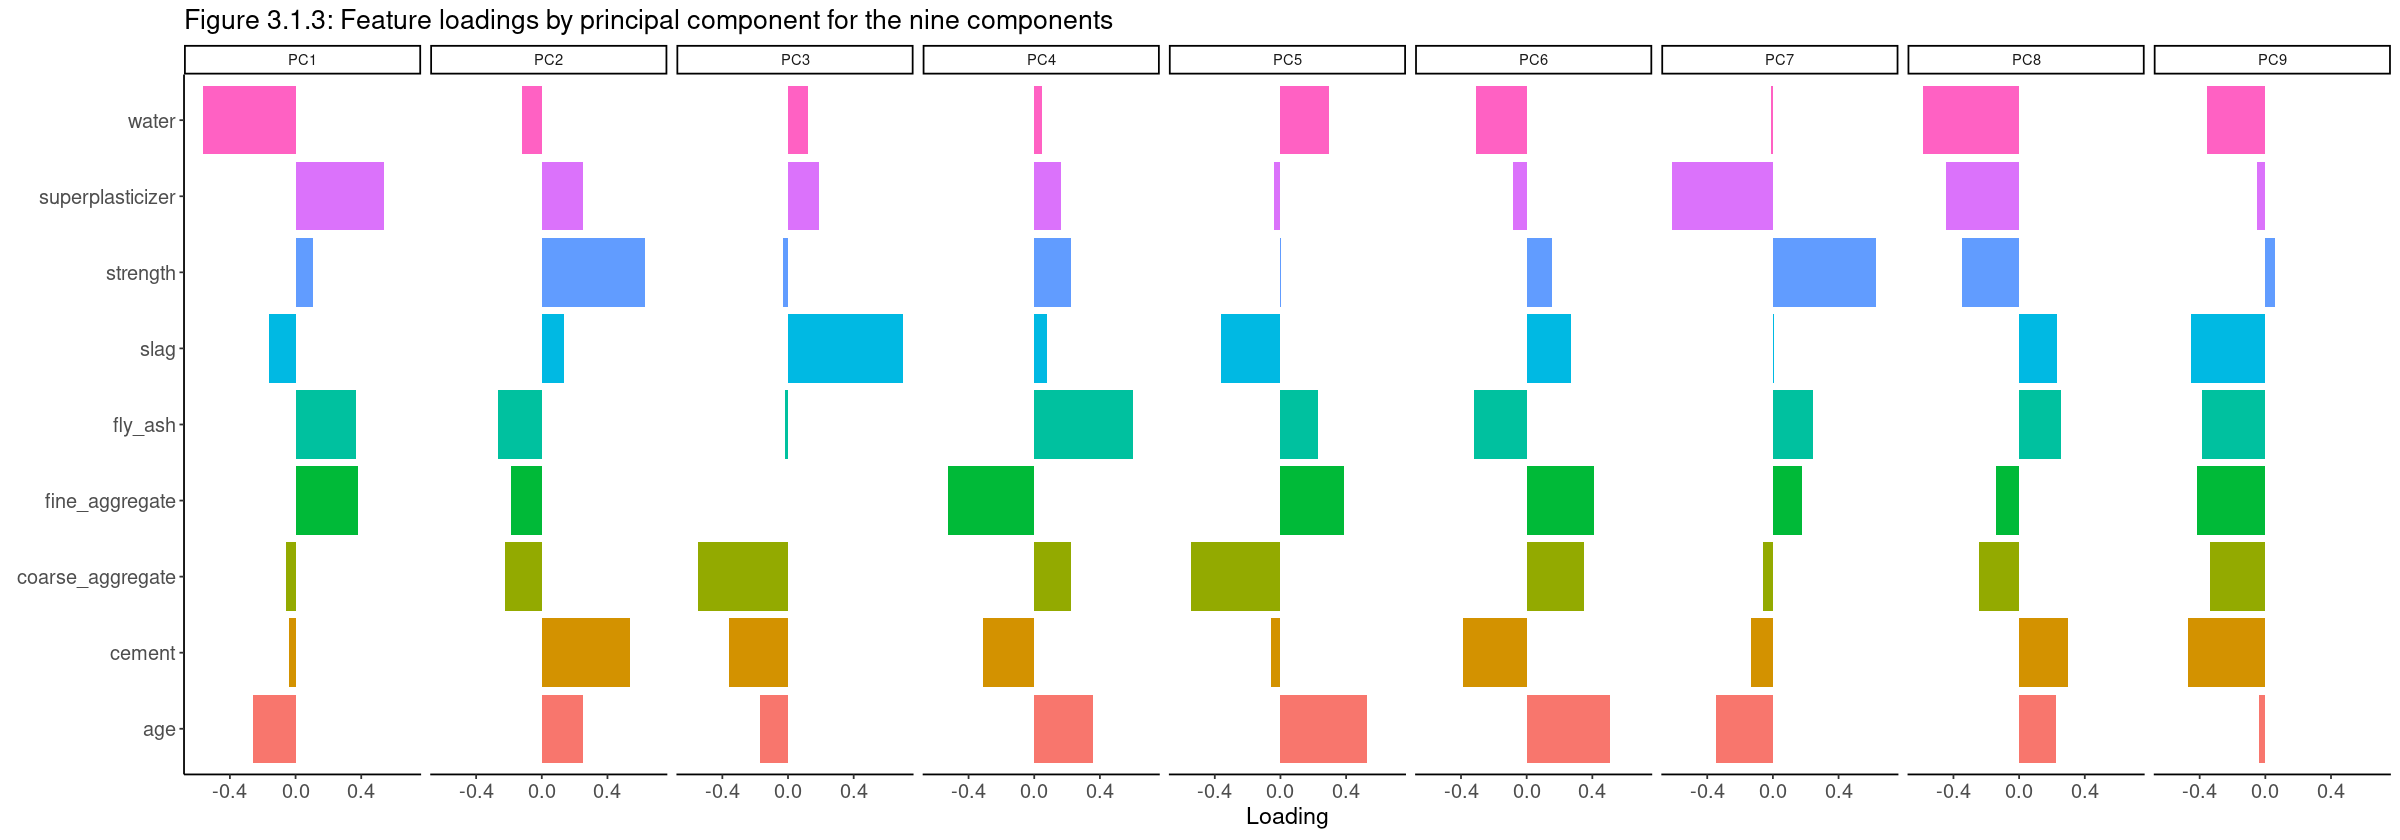

In [28]:
options(repr.plot.width=20, repr.plot.height=NULL)
pca1_loadings %>%
   filter(component %in% paste0("PC", 1:9)) %>%
   mutate(component = fct_inorder(component)) %>%
   ggplot(aes(value, terms, fill = terms)) +
   geom_col(show.legend = FALSE) +
   facet_wrap(~component, nrow = 1) +
   labs(x = "Loading", 
        y = NULL, 
        title = "Figure 3.1.3: Feature loadings by principal component for the nine components") +
   theme_report()

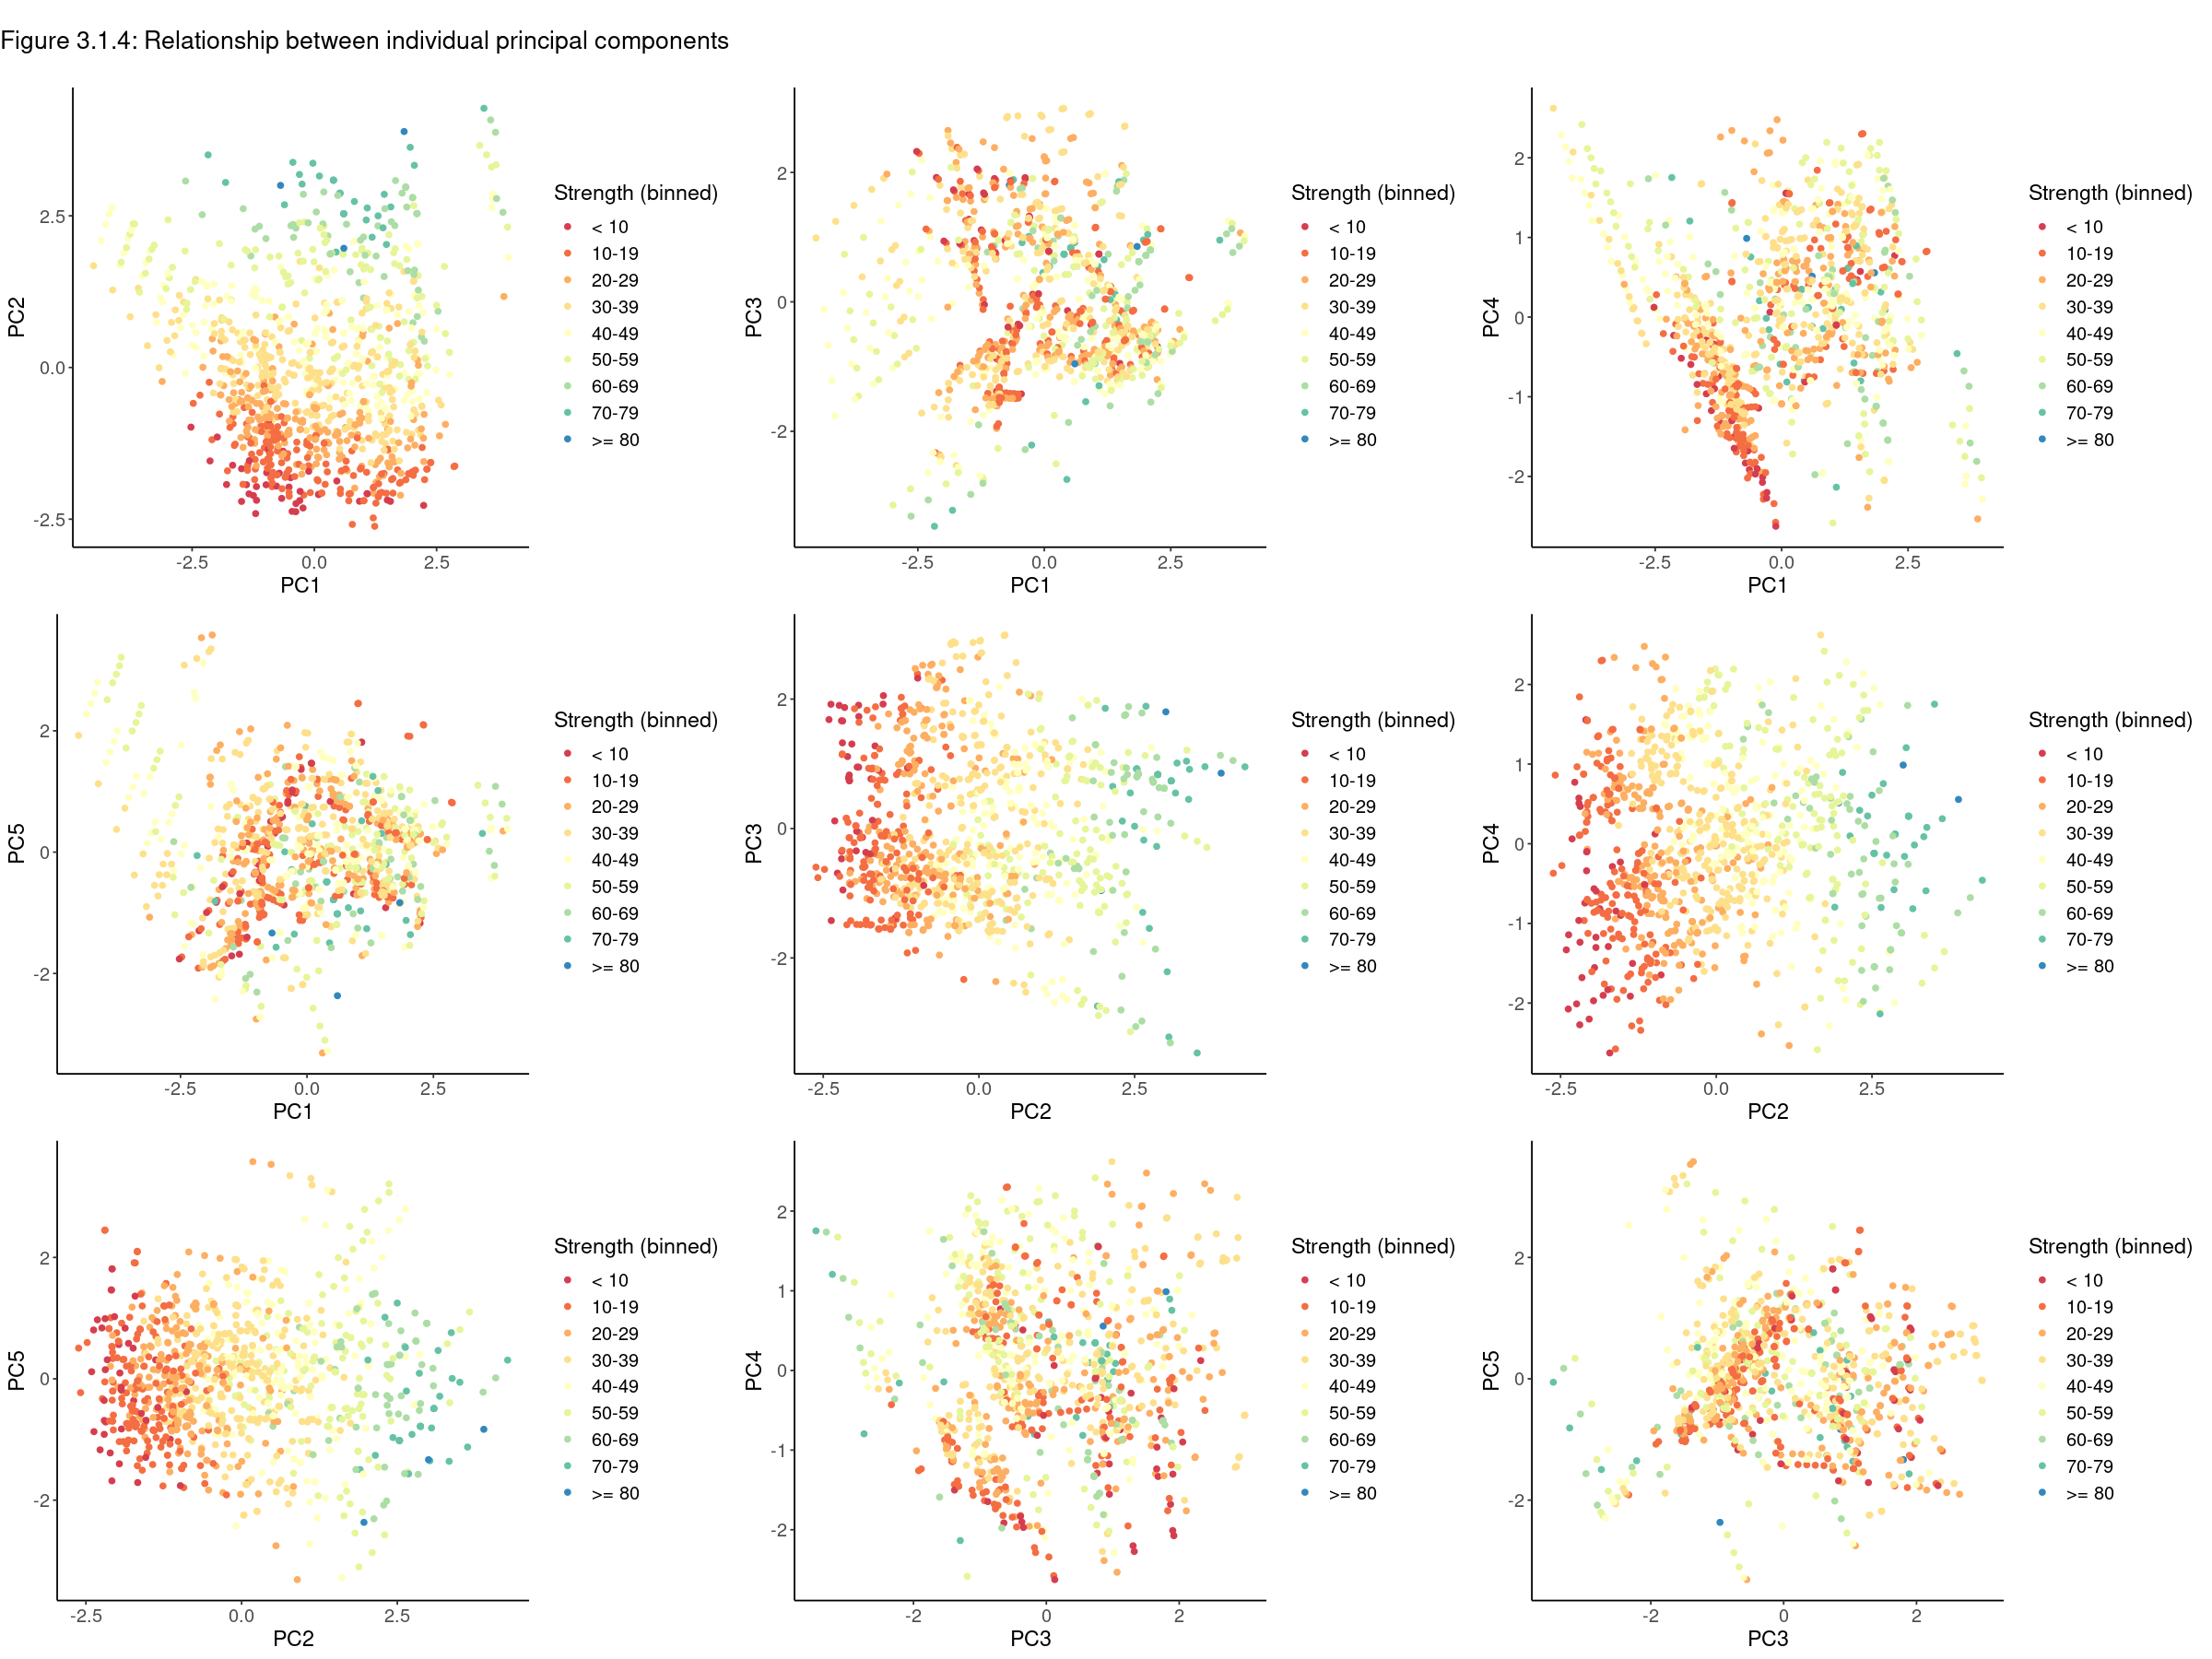

In [29]:
baked_pca1 <- bake(pca1_prep, df) %>% bind_cols(df)
var_grid1 <- expand.grid(1:5, 1:5) %>% filter(!duplicated(paste0(pmin(Var1, Var2), pmax(Var1, Var2))), Var1 != Var2)

baked_pca1 <- baked_pca1 %>%
    mutate(strength_bin = case_when(
        strength < 10 ~ "< 10",
        strength >= 10 & strength < 20 ~ "10-19",
        strength >= 20 & strength < 30 ~ "20-29",
        strength >= 30 & strength < 40 ~ "30-39",
        strength >= 40 & strength < 50 ~ "40-49",
        strength >= 50 & strength < 60 ~ "50-59",
        strength >= 60 & strength < 70 ~ "60-69",
        strength >= 70 & strength < 80 ~ "70-79",
        TRUE ~ ">= 80"
        )
           )
baked_pca1$strength_bin <- factor(baked_pca1$strength_bin, levels = c("< 10", "10-19", "20-29", "30-39", "40-49", "50-59", "60-69", "70-79", ">= 80"))

# plot one by one
# for (row in 1:nrow(var_grid1)) {
#     xvar <- colnames(baked_pca1)[var_grid1$Var2[row]]
#     yvar <- colnames(baked_pca1)[var_grid1$Var1[row]]
    
#     ggpl <- ggplot(baked_pca1, aes(x = .data[[xvar]], y = .data[[yvar]])) +
#     geom_point(aes(colour = strength_bin)) +
#     # geom_jitter(shape = 21, fill = "seagreen", colour = "white") +
#     scale_colour_brewer(palette = "Spectral") +
#     labs(title = paste0("Figure 3.1.", row+3, ": Relationship between ", xvar, " and ", yvar),
#          colour = "Strength (binned)") +
#     theme_report()

#     print(ggpl)
# }

# plot in a grid
nums <- seq(1, nrow(var_grid1)-1, 1)
pltnames <- paste0("p", nums)
xvars <- colnames(baked_pca1)[var_grid1$Var2[nums]]
yvars <- colnames(baked_pca1)[var_grid1$Var1[nums]]

pc_scplot <- function(xvar, yvar, i) {
    ggplot(baked_pca1, aes(x = .data[[xvar]], y = .data[[yvar]])) +
    geom_point(aes(colour = strength_bin)) +
    scale_colour_brewer(palette = "Spectral") +
    labs(colour = "Strength (binned)") +
    theme_report()
    }

plot_list <- map2(xvars, yvars, pc_scplot)

options(repr.plot.width=20, repr.plot.height=15)
plot_row <- ggarrange(plotlist = plot_list)
title <- ggdraw() + draw_label("Figure 3.1.4: Relationship between individual principal components", x = 0, hjust = 0, size = 16)
plot_grid(title, plot_row, ncol = 1, rel_heights = c(0.05, 1))

These are interesting (and very visually appealling), and indicate that the clearest separation between different binned values of compressive strength occurs between the second principal component and each of the other four.

### Expanded Dataset

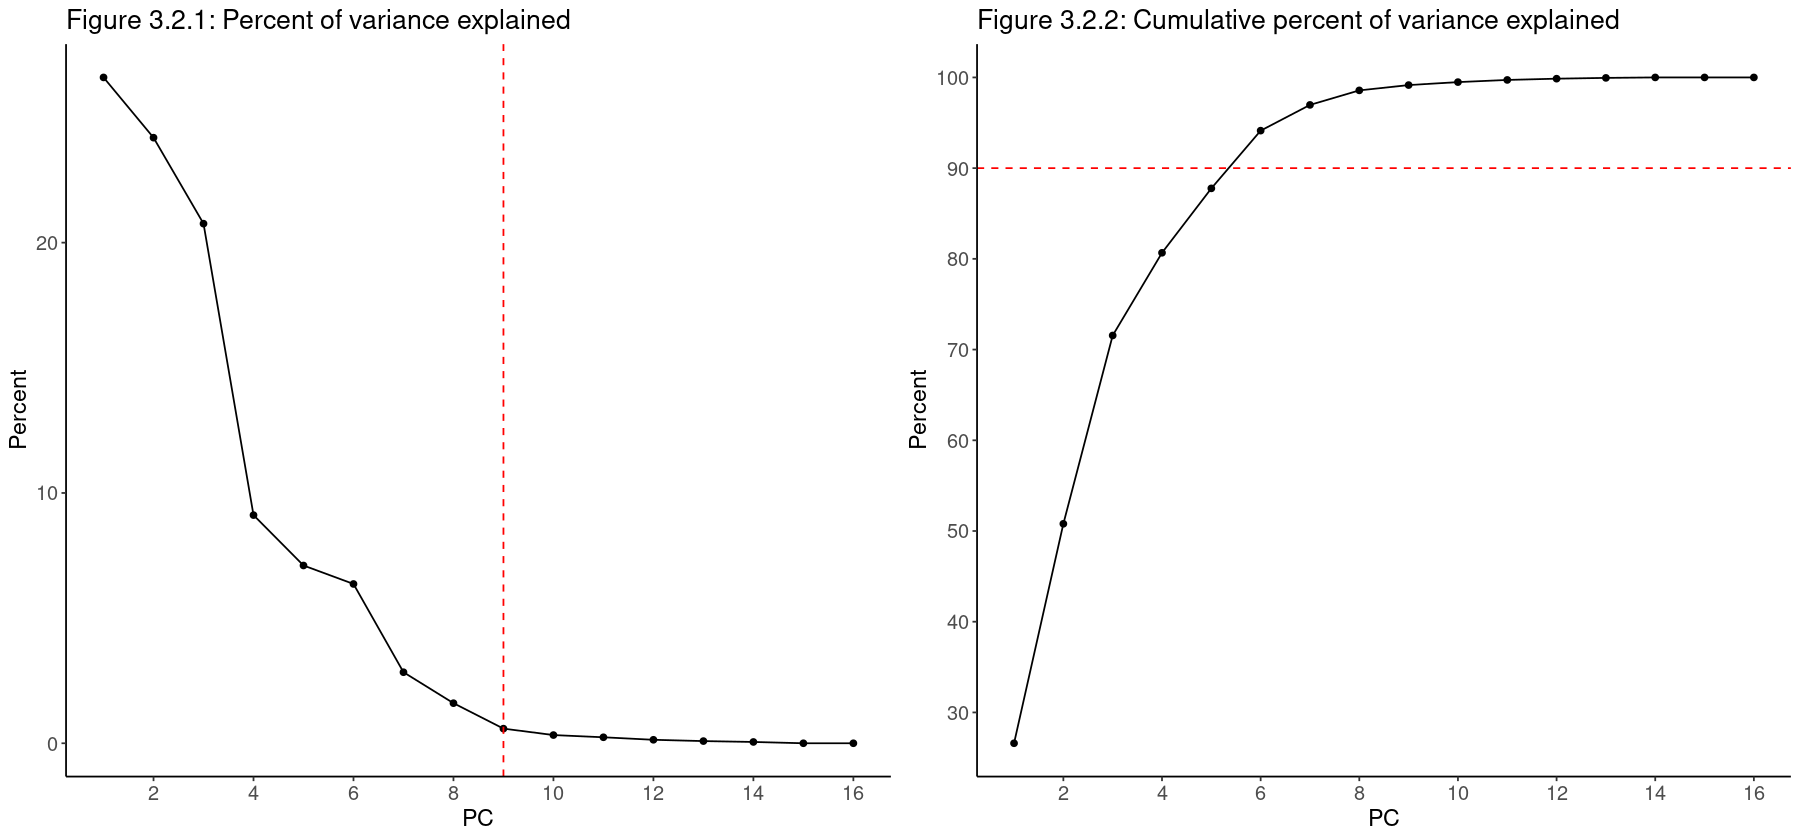

In [30]:
pca2_rec <- recipe(~., data = df_all)

pca2_trans <- pca2_rec %>%
    step_normalize(all_predictors(), id = "normalise") %>%
    step_pca(all_predictors(), num_comp = 5, id = "pca")

pca2_prep <- prep(pca2_trans)
pca2_loadings = tidy(pca2_prep, id = "pca")
pca2_variance = tidy(pca2_prep, id = "pca", type = "variance") # includes variance, cumulative variance, percent variance and cumulative percent variance

p1 <- pca2_variance %>%
    filter(terms == "percent variance") %>%
    ggplot(aes(x = component, y = value)) +
    geom_line() +
    geom_point() +
    geom_vline(xintercept = 9, col = "red", linetype = "dashed") +
    scale_x_continuous(breaks = seq(2, 16, 2)) +
    labs(x = "PC", 
         y = "Percent",
         title = "Figure 3.2.1: Percent of variance explained") +
    theme_report()

p2 <- pca2_variance %>%
    filter(terms == "cumulative percent variance") %>%
    ggplot(aes(x = component, y = value)) +
    geom_line() +
    geom_point() +
    geom_hline(yintercept = 90, col = "red", linetype = "dashed") +
    scale_x_continuous(breaks = seq(2, 16, 2)) +
    scale_y_continuous(breaks = seq(0, 100, 10)) +
    labs(x = "PC", 
         y = "Percent",
         title = "Figure 3.2.2: Cumulative percent of variance explained") +
    theme_report()

options(repr.plot.width=15, repr.plot.height=NULL)
plot_grid(p1, p2, ncol = 2)

The first plot (Figure 3.2.1) suggests that 9 components should be extracted based on the elbow method, but the cumulative percentage of variance explained (Figure 3.2.2), indicates that 5 or 6 components are sufficient as this number explains well over 80% of the variation in the data. (In fact, we could get away with 4 factors, which is just about dead on 80% of cumulative variance explained).

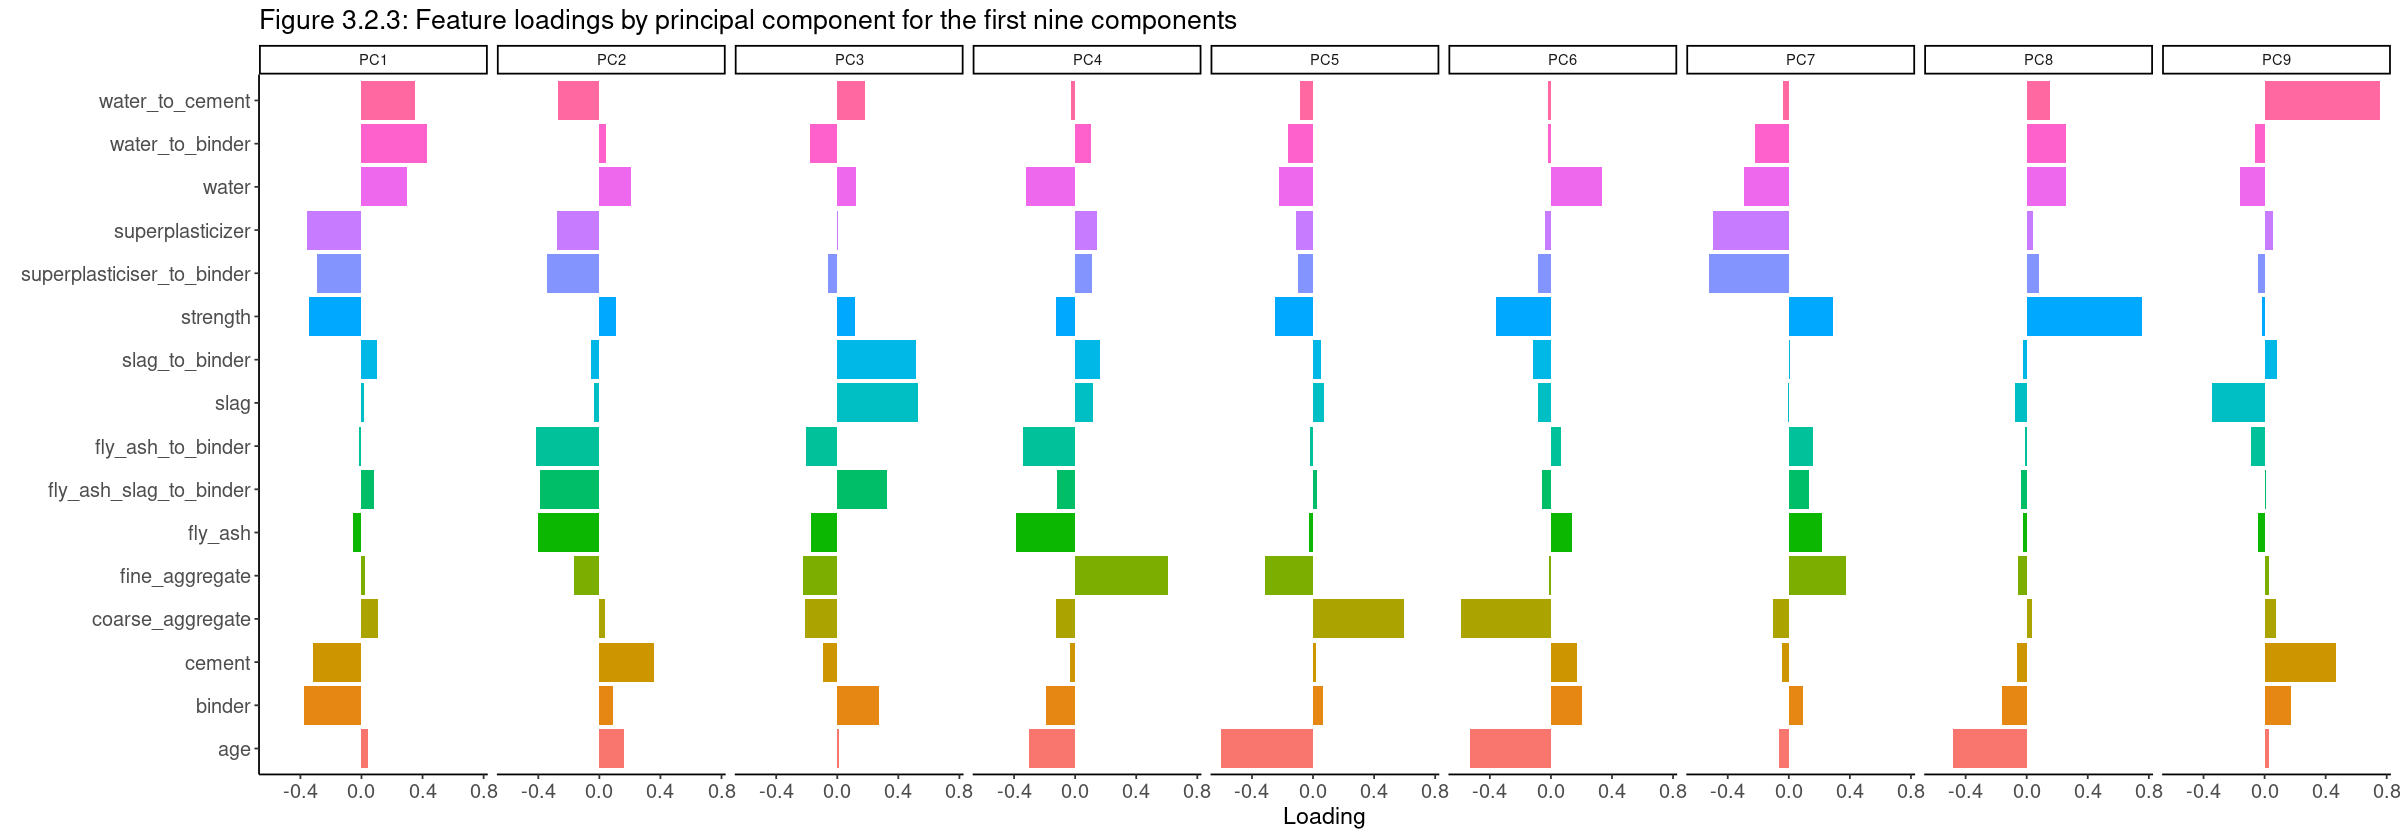

In [31]:
options(repr.plot.width=20, repr.plot.height=NULL)
pca2_loadings %>%
   filter(component %in% paste0("PC", 1:9)) %>%
   mutate(component = fct_inorder(component)) %>%
   ggplot(aes(value, terms, fill = terms)) +
   geom_col(show.legend = FALSE) +
   facet_wrap(~component, nrow = 1) +
   labs(x = "Loading", 
        y = NULL, 
        title = "Figure 3.2.3: Feature loadings by principal component for the first nine components") +
   theme_report()

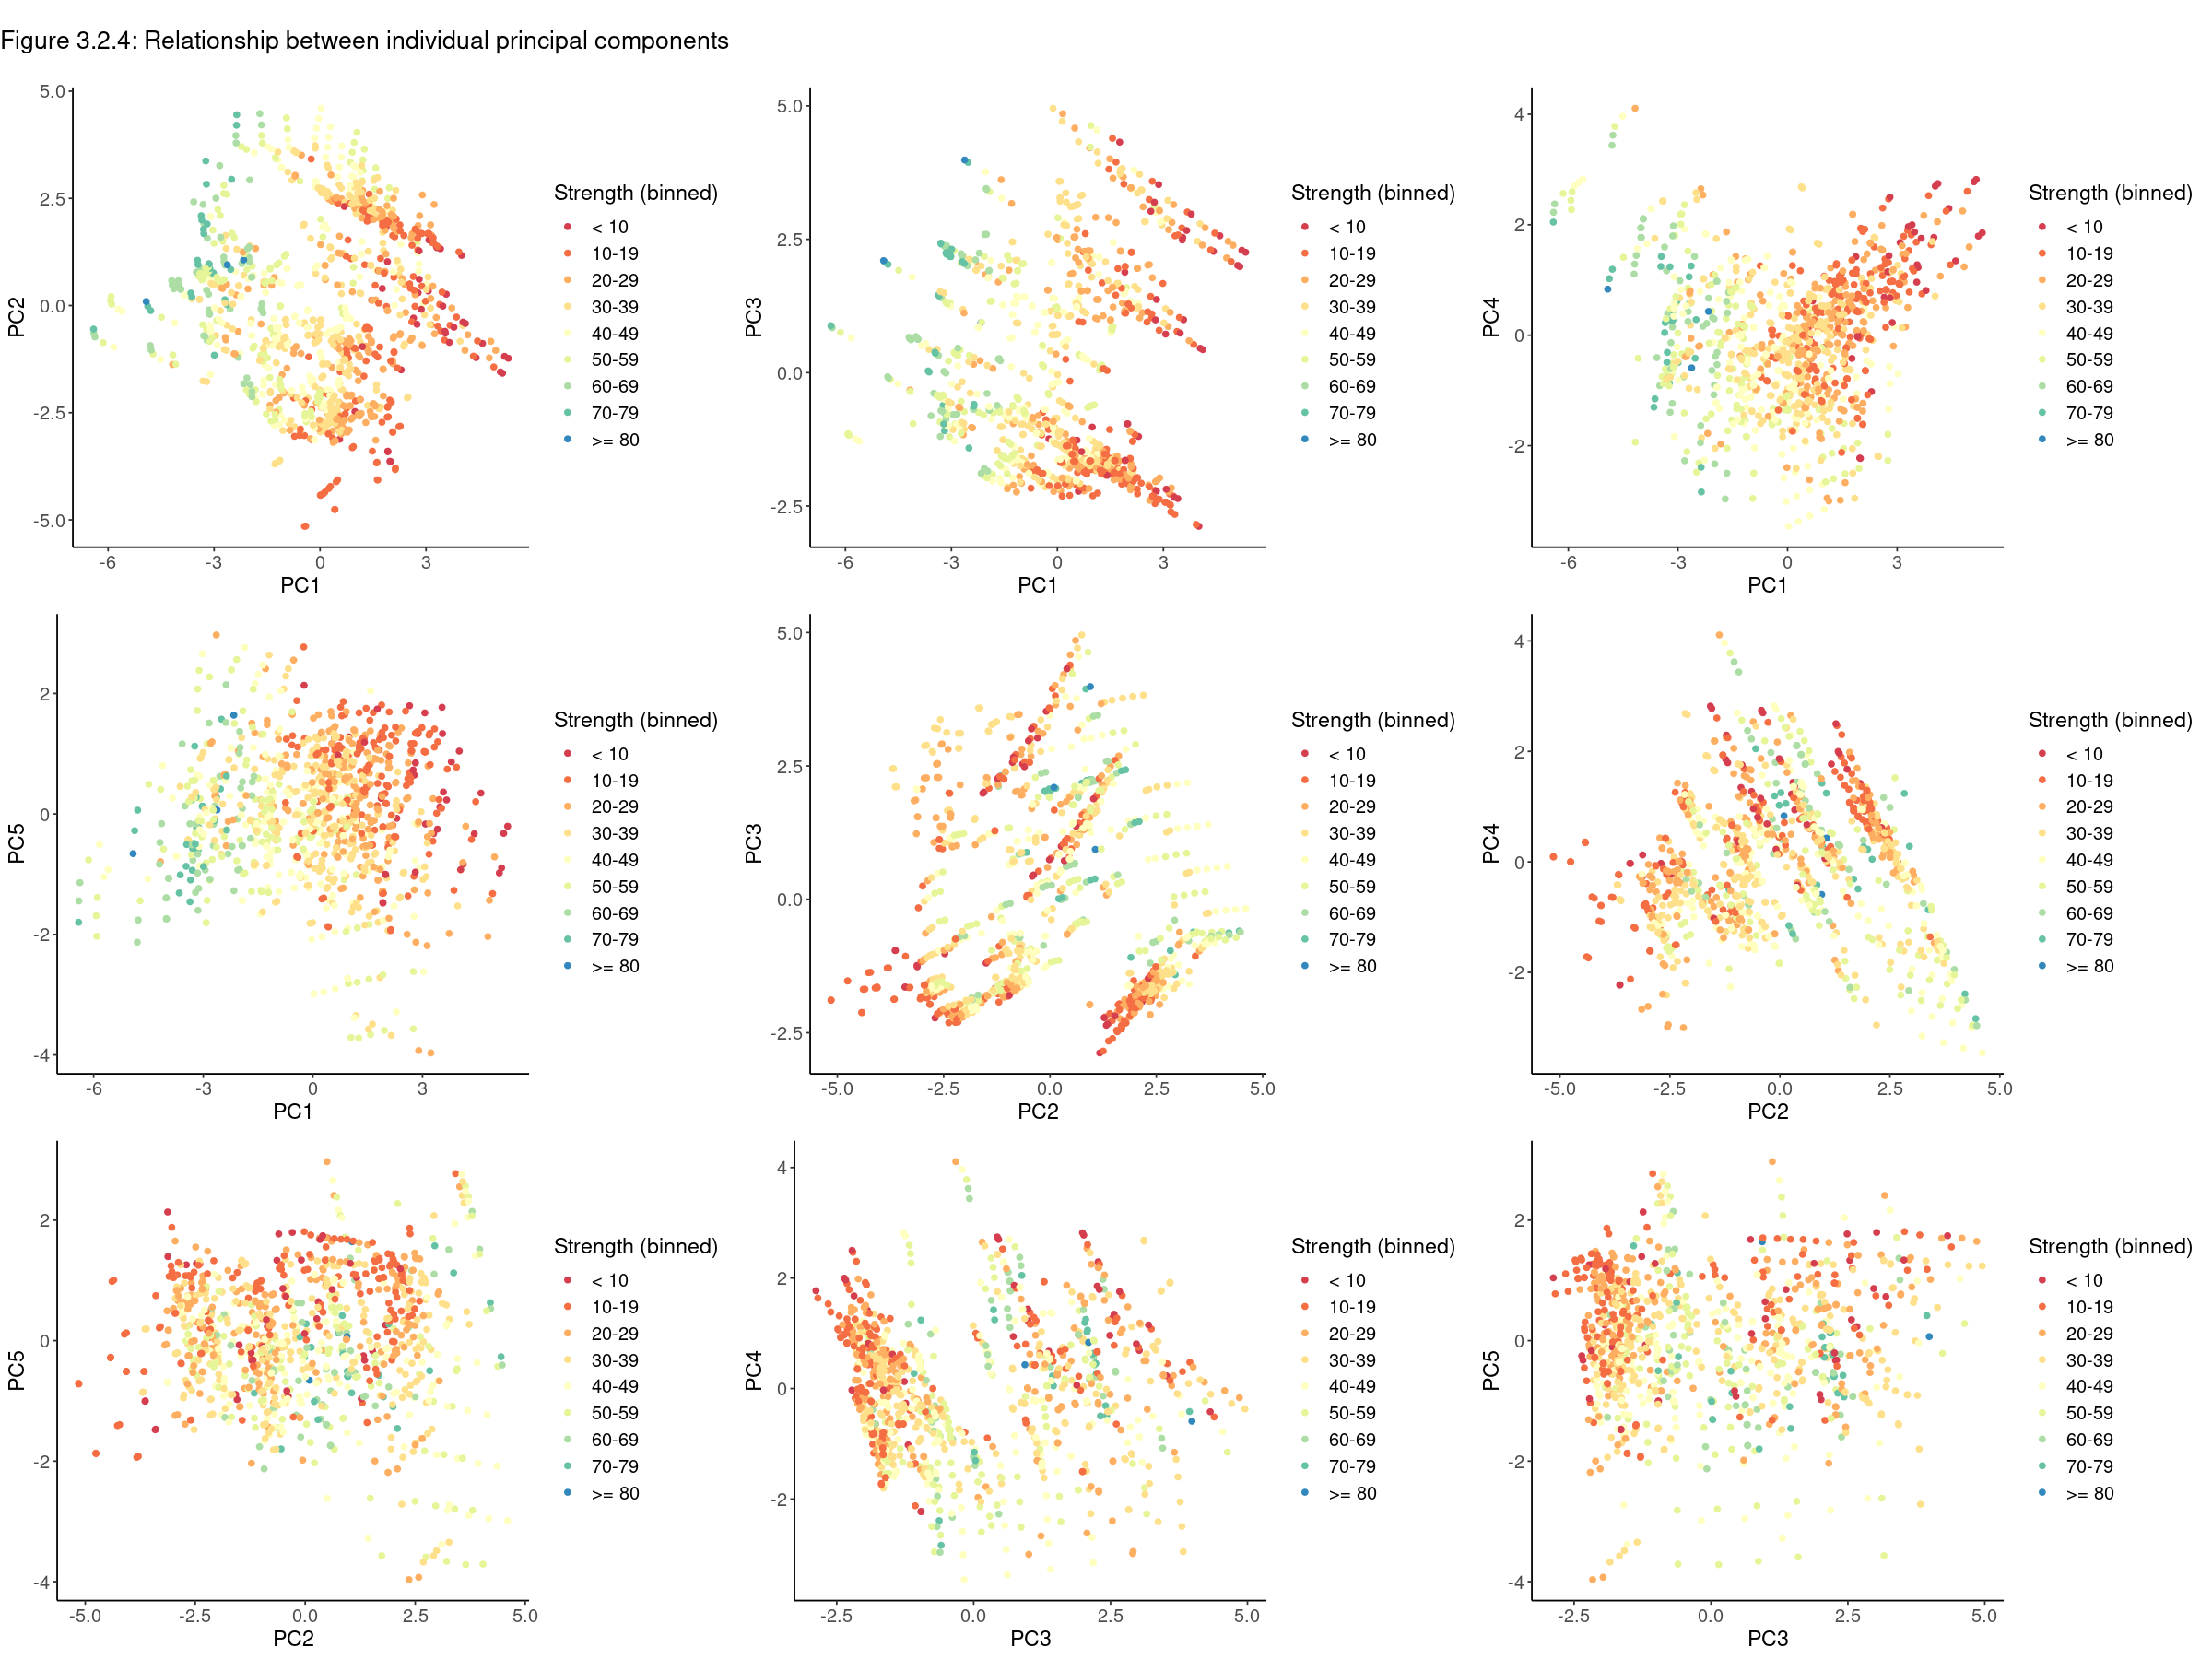

In [32]:
baked_pca2 <- bake(pca2_prep, df_all) %>% bind_cols(df_all)
var_grid2 <- expand.grid(1:5, 1:5) %>% filter(!duplicated(paste0(pmin(Var1, Var2), pmax(Var1, Var2))), Var1 != Var2)

baked_pca2 <- baked_pca2 %>%
    mutate(strength_bin = case_when(
        strength < 10 ~ "< 10",
        strength >= 10 & strength < 20 ~ "10-19",
        strength >= 20 & strength < 30 ~ "20-29",
        strength >= 30 & strength < 40 ~ "30-39",
        strength >= 40 & strength < 50 ~ "40-49",
        strength >= 50 & strength < 60 ~ "50-59",
        strength >= 60 & strength < 70 ~ "60-69",
        strength >= 70 & strength < 80 ~ "70-79",
        TRUE ~ ">= 80"
        )
           )
baked_pca2$strength_bin <- factor(baked_pca2$strength_bin, levels = c("< 10", "10-19", "20-29", "30-39", "40-49", "50-59", "60-69", "70-79", ">= 80"))

# plot one by one
# options(repr.plot.width=NULL, repr.plot.height=NULL)
# for (row in 1:nrow(var_grid2)) {
#     x_var <- colnames(baked_pca2)[var_grid2$Var2[row]]
#     y_var <- colnames(baked_pca2)[var_grid2$Var1[row]]
    
#     ggpl <- ggplot(baked_pca2, aes(x = .data[[x_var]], y = .data[[y_var]])) +
#     geom_point(aes(colour = strength_bin)) +
#     # geom_jitter(shape = 21, fill = "seagreen", colour = "white") +
#     scale_colour_brewer(palette = "Spectral") +
#     labs(title = paste0("Figure 3.3.", row+3, ": Relationship between ", x_var, " and ", y_var),
#          colour = "Strength (binned)") +
#     theme_report()

#     print(ggpl)
# }

# plot in a grid
nums <- seq(1, nrow(var_grid2)-1, 1)
pltnames <- paste0("p", nums)
xvars <- colnames(baked_pca2)[var_grid2$Var2[nums]]
yvars <- colnames(baked_pca2)[var_grid2$Var1[nums]]

pc_scplot2 <- function(xvar, yvar, i) {
    ggplot(baked_pca2, aes(x = .data[[xvar]], y = .data[[yvar]])) +
    geom_point(aes(colour = strength_bin)) +
    scale_colour_brewer(palette = "Spectral") +
    labs(colour = "Strength (binned)") +
    theme_report()
    }

plot_list <- map2(xvars, yvars, pc_scplot2)

options(repr.plot.width=20, repr.plot.height=15)
plot_row <- ggarrange(plotlist = plot_list)
title <- ggdraw() + draw_label("Figure 3.2.4: Relationship between individual principal components", x = 0, hjust = 0, size = 16)
plot_grid(title, plot_row, ncol = 1, rel_heights = c(0.05, 1))

These are interesting (and very visually appealling), and indicate that the clearest separation between different binned values of compressive strength occurs between the first principal component and each of the other four.

## Regression Modelling - Initial Dataset

In [33]:
# split data into training and test sets
set.seed(22)

all_data <- baked_pca1 %>% select(-strength_bin)
data_split <- initial_split(all_data, prop = 0.7) # includes the pca components

all_train_data <- training(data_split)
all_test_data <- testing(data_split)

# unfortunately, there's an issue with the environment so I can't use cross-validation in model training

# identify metrics to use for performance assessment
multi_metrics <- metric_set(mae, mape, mpe, rmse, rsq, smape)

In [34]:
train_data <- all_train_data %>% select(cement:strength)
test_data <- all_test_data %>% select(cement:strength)

### Linear Regression - Baseline

In [35]:
# workflow approach
# create the recipe
# baseline_recipe <- recipe(strength ~., data = train_data)

# # check the recipe output
# mlr_recipe <- baseline_recipe %>% 
#     prep() %>% 
#     bake(new_data = test_data)

# mlr_wflow <- workflow() %>% add_model(linear_reg()) %>% add_recipe(baseline_recipe)
# mlr_fit <- mlr_wflow %>% last_fit(split = data_split)
# mlr_metrics <- mlr_fit %>% collect_metrics() # metrics on test data
# mlr_results <- mlr_fit %>% collect_predictions() # on test data

# ggplot(mlr_results, aes(.pred, strength)) +
#     geom_point(color = '#006EA1', alpha = 0.5) +
#     geom_abline(intercept = 0, slope = 1, color = 'red') +
#     labs(title = 'Linear Regression Results - Concrete Test Set',
#          x = 'Predicted strength',
#          y = 'Actual strength') +
#     theme_report()

# can't use VIP with this methodology

In [36]:
# create the recipe
baseline_recipe <- recipe(strength ~., data = train_data)

# and bake it on the training data
mlr_baked <- baseline_recipe %>% 
    prep() %>% 
    bake(new_data = NULL)

# create the linear model and fit it to the baked data
mlr_fit <- linear_reg() %>%
    set_engine("lm") %>% # not strictly necessary but makes it explicit
    fit(formula = strength ~., data = mlr_baked)

# view model parameters
tidied_mlr <- tidy(mlr_fit, conf.int = TRUE)

# view fitted performance
glanced_mlr <- glance(mlr_fit)
print("Table 4.1.1: Training data performance")
glanced_mlr

# obtain model residuals etc
aug_mlr <- augment(mlr_fit$fit, mlr_baked, interval = "confidence") %>% 
    rowid_to_column() %>%
    select(rowid, strength:.std.resid)

# view variable importance on the fitted data
# vip(mlr_fit, aesthetics = list(fill = "darkcyan"), include_type = TRUE) + 
#     labs(title = "Figure 4.1.1: Feature importance") + 
#     theme_report()

# model diagnostics confirm that the model would benefit from improvement

[1] "Table 4.1.1: Training data performance"


r.squared adj.r.squared sigma    statistic p.value       df logLik   AIC    
1 0.6076907 0.6032827     10.35181 137.8618  3.704142e-139 8  -2703.62 5427.24
  BIC      deviance df.residual nobs
1 5473.046 76297.95 712         721

The table above indicates that the current set of predictors is doing a fairly poor job of predicting concrete strength.

In [37]:
# bake the recipe on the test data
mlr_test_baked <- baseline_recipe %>% 
    prep() %>% 
    bake(new_data = test_data)

mlr_preds <- mlr_test_baked %>% 
    select(strength) %>% 
    bind_cols(
        predict(mlr_fit, new_data = mlr_test_baked)
        )

# view predictive performance
mlr_perf <- multi_metrics(mlr_preds, truth = strength, estimate = .pred) %>% 
    pivot_wider(names_from = .metric, values_from = .estimate) %>% 
    select(-.estimator)
print("Table 4.1.2: Predictive performance")
mlr_perf

# ggplot(mlr_preds, aes(.pred, strength)) +
#     geom_point(color = '#006EA1', alpha = 0.5) +
#     geom_smooth(se = FALSE, colour = "red") +
# #    geom_abline(intercept = 0, slope = 1, color = 'red') +
#     labs(title = 'Figure 4.1.2: Predicted vs actual compressive strength',
#          x = 'Predicted strength',
#          y = 'Actual strength') +
#     theme_report()

[1] "Table 4.1.2: Predictive performance"


mae      mape     mpe       rmse     rsq       smape  
1 8.427723 29.81516 -10.16254 10.54771 0.6320252 25.7073

### Linear Regression - Feature-Transformed

In [38]:
# create the recipe
transformation_recipe <- recipe(strength ~., data = train_data) %>%
    step_YeoJohnson(all_predictors())

# bake the recipe on the training data
mlrt_baked <- transformation_recipe %>% 
    prep() %>% 
    bake(new_data = NULL)

# create the linear model and fit it to the baked data
mlrt_fit <- linear_reg() %>%
    set_engine("lm") %>% # not strictly necessary but makes it explicit
    fit(formula = strength ~., data = mlrt_baked)

# view model parameters
tidied_mlrt <- tidy(mlrt_fit, conf.int = TRUE)

# view fitted performance
glanced_mlrt <- glance(mlrt_fit)
print("Table 4.2.1: Training data performance")
glanced_mlrt

# obtain model residuals etc
aug_mlrt <- augment(mlrt_fit$fit, mlrt_baked, interval = "confidence") %>% 
    rowid_to_column() %>%
    select(rowid, strength:.std.resid)

# view variable importance on the fitted data
# vip(mlrt_fit, aesthetics = list(fill = "darkcyan"), include_type = TRUE) + 
#     labs(title = "Figure 4.2.1: Feature importance") + 
#     theme_report()

[1] "Table 4.2.1: Training data performance"


r.squared adj.r.squared sigma    statistic p.value       df logLik   
1 0.8023314 0.8001104     7.348031 361.2486  8.938532e-245 8  -2456.512
  AIC      BIC      deviance df.residual nobs
1 4933.024 4978.831 38443.41 712         721

So just by using a variable transformation, we can very much improve the results. 

In [39]:
## view model diagnostics - better but not perfect
# residuals vs fitted
# ggplot(aug_mlrt, aes(.fitted, .resid)) +
#     geom_point(alpha = .5, col = "darkcyan") +
#     geom_smooth(se = FALSE, colour = "red") +
#     geom_hline(yintercept = 0, linetype = "dashed") +
#     labs(title = "Residuals vs Fitted", x = "Fitted values", y = "Residuals") +
#     theme_report()

# # normal qq plot
# ggplot(aug_mlrt, aes(sample = .resid)) +
#     stat_qq(alpha = .5, col = "darkcyan") +
#     stat_qq_line(linetype = "dashed") +
#     labs(title = "Normal Q-Q", x = "Theoretical quantiles", y = "Residuals") +
#     theme_report()

# # scale-location
# ggplot(aug_mlrt, aes(.fitted, sqrt(.std.resid))) +
#     geom_point(alpha = .5, col = "darkcyan") +
#     geom_smooth(se = FALSE, colour = "red") +
#     labs(title = "Scale-Location", x = "Fitted values", y = "Standardised residuals^(1/2)") +
#     theme_report()

# # residuals vs leverage
# ggplot(aug_mlrt, aes(.cooksd, .std.resid)) +
#     geom_point(alpha = .5, col = "darkcyan") +
#     geom_smooth(se = FALSE, colour = "red") +
#     geom_hline(yintercept = 0, linetype = "dashed") +
#     geom_vline(xintercept = 0, linetype = "dashed") +
#     labs(title = "Residuals vs Leverage", x = "Leverage", y = "Standardised residuals") +
#     theme_report()

In [40]:
# make predictions on the test data
# bake the recipe on the test data
mlrt_test_baked <- transformation_recipe %>% 
    prep() %>% 
    bake(new_data = test_data)

mlrt_preds <- mlrt_test_baked %>% 
    select(strength) %>% 
    bind_cols(
        predict(mlrt_fit, new_data = mlrt_test_baked)
        )

# view predictive performance
mlrt_perf <- multi_metrics(mlrt_preds, truth = strength, estimate = .pred) %>% 
    pivot_wider(names_from = .metric, values_from = .estimate) %>% 
    select(-.estimator)
print("Table 4.2.2: Linear regression model with a Yeo-Johnson transformation predictive performance")
mlrt_perf

# ggplot(mlrt_preds, aes(.pred, strength)) +
#     geom_point(color = '#006EA1', alpha = 0.5) +
#     geom_smooth(se = FALSE, colour = "red") +
# #    geom_abline(intercept = 0, slope = 1, color = 'red') +
#     labs(title = 'Figure 4.2.2: Predicted vs actual compressive strength',
#          x = 'Predicted strength',
#          y = 'Actual strength') +
#     theme_report()

[1] "Table 4.2.2: Linear regression model with a Yeo-Johnson transformation predictive performance"


mae      mape     mpe       rmse     rsq       smape   
1 5.837867 19.70929 -1.614814 7.567871 0.8112086 19.15673

### Glmnet Regression

In [41]:
# create the recipe
glm_recipe <- recipe(strength ~., data = train_data) %>%
    step_YeoJohnson(all_predictors()) %>%
    step_normalize(all_predictors()) %>%
    prep(training = train_data, retain = TRUE)

# bake the recipe on the training data
glm_baked <- bake(glm_recipe, new_data = NULL)
# bake the recipe on the test data
glm_test_baked <- bake(glm_recipe, new_data = test_data)

# define the hyperparameter grid
mix_opt <- c(0, 0.25, 0.5, 0.75, 1)
penalty_opt <- c(0.0001, 0.001, 0.01, 0.1, 1)

param_grid <- expand.grid(mix_opt, penalty_opt)

all_glm_perf = NULL
for (index in 1:nrow(param_grid)) { 
    row = param_grid[index, ]
    
    # fit the model
    glm_fit <- linear_reg(penalty = row$Var2, mixture = row$Var1) %>%
    set_engine("glmnet") %>%
    fit(formula = strength ~., data = glm_baked)
    
    # view model parameters
    tidied_glm <- tidy(glm_fit, conf.int = TRUE)
    # print(tidied_glm)

    # make predictions on the test data
    glm_preds <- glm_test_baked %>% 
        select(strength) %>% 
        bind_cols(
            predict(glm_fit, new_data = glm_test_baked)
            )

    # view predictive performance
    glm_perf <- multi_metrics(glm_preds, truth = strength, estimate = .pred)
    glm_perf <- glm_perf %>% mutate(model = rep(paste0("model_", index), times = 6))
    
    # combine all performance data into a single dataframe
    all_glm_perf = bind_rows(all_glm_perf, glm_perf)
}

# add columns for the penalty and mixture hyperparameter combinations
all_glm_perf <- all_glm_perf %>%
    mutate(penalty = rep(penalty_opt, each = 6 * 5, length.out = nrow(all_glm_perf)),
           mixture = rep(mix_opt, each = 6, length.out = nrow(all_glm_perf)))

# pivot to get one line per model
all_glm_perf_wide <- all_glm_perf %>% 
    pivot_wider(names_from = .metric, values_from = .estimate) %>% 
    select(-.estimator)
# all_glm_perf_wide

print(paste0("The best model according to MAE was: ", (all_glm_perf_wide %>% arrange(mae))$model[1], " with a value of ", round((all_glm_perf_wide %>% arrange(mae))$mae[1], 4)))
print(paste0("The best model according to MAPE was: ", (all_glm_perf_wide %>% arrange(mape))$model[1], " with a value of ", round((all_glm_perf_wide %>% arrange(mape))$mape[1], 4)))
print(paste0("The best model according to MPE was: ", (all_glm_perf_wide %>% arrange(mpe))$model[1], " with a value of ", round((all_glm_perf_wide %>% arrange(mpe))$mpe[1], 4)))
print(paste0("The best model according to RMSE was: ", (all_glm_perf_wide %>% arrange(rmse))$model[1], " with a value of ", round((all_glm_perf_wide %>% arrange(rmse))$rmse[1], 4)))
print(paste0("The best model according to RSQ was: ", (all_glm_perf_wide %>% arrange(desc(rsq)))$model[1], " with a value of ", round((all_glm_perf_wide %>% arrange(desc(rsq)))$rsq[1], 4)))
print(paste0("The best model according to SMAPE was: ", (all_glm_perf_wide %>% arrange(smape))$model[1], " with a value of ", round((all_glm_perf_wide %>% arrange(smape))$smape[1], 4)))

[1] "The best model according to MAE was: model_5 with a value of 5.8462"
[1] "The best model according to MAPE was: model_20 with a value of 19.6312"
[1] "The best model according to MPE was: model_25 with a value of -7.2682"
[1] "The best model according to RMSE was: model_5 with a value of 7.575"
[1] "The best model according to RSQ was: model_2 with a value of 0.8111"
[1] "The best model according to SMAPE was: model_22 with a value of 18.6377"


The model to win the majority vote is model_5, which is a pure lasso model with a very small amount of regularisation.

In [42]:
print("Table 4.3.1: Performance statistics of the chosen model from the hyperparameter search")
all_glm_perf_wide %>% filter(model == "model_5")

[1] "Table 4.3.1: Performance statistics of the chosen model from the hyperparameter search"


model   penalty mixture mae      mape     mpe       rmse     rsq      
1 model_5 1e-04   1       5.846182 19.67242 -1.807152 7.574998 0.8111204
  smape   
1 19.05041

In [43]:
# refit the glm to the training data with the chosen hyperparameters
# create the recipe
glm_recipe <- recipe(strength ~., data = train_data) %>%
    step_YeoJohnson(all_predictors()) %>%
    step_normalize(all_predictors()) %>%
    prep(training = train_data, retain = TRUE)

# bake the recipe on the training data
glm_baked <- bake(glm_recipe, new_data = NULL)

# create the linear model and fit it to the baked data
glm_fit <- linear_reg(penalty = 0.0001, mixture = 1) %>%
    set_engine("glmnet") %>%
    fit(formula = strength ~., data = glm_baked)

# view model parameters
tidied_glm <- tidy(glm_fit, conf.int = TRUE)

# view variable importance on the fitted data
# vip(glm_fit, aesthetics = list(fill = "darkcyan"), include_type = TRUE) + 
#     labs(title = "Figure 4.3.1: Feature importance") + 
#     theme_report()

In [44]:
# make predictions on the test data
# bake the recipe on the test data
glm_test_baked <- glm_recipe %>% 
    prep() %>% 
    bake(new_data = test_data)

glm_preds <- glm_test_baked %>% 
    select(strength) %>% 
    bind_cols(
        predict(glm_fit, new_data = glm_test_baked)
        )

# view predictive performance
glm_perf <- multi_metrics(glm_preds, truth = strength, estimate = .pred) %>% 
    pivot_wider(names_from = .metric, values_from = .estimate) %>% 
    select(-.estimator)
print("Table 4.3.2: Elastic net regression model predictive performance")
mlrt_perf

# ggplot(glm_preds, aes(.pred, strength)) +
#     geom_point(color = '#006EA1', alpha = 0.5) +
#     geom_smooth(se = FALSE, colour = "red") +
# #    geom_abline(intercept = 0, slope = 1, color = 'red') +
#     labs(title = 'Figure 4.3.2: Predicted vs actual compressive strength',
#          x = 'Predicted strength',
#          y = 'Actual strength') +
#     theme_report()

[1] "Table 4.3.2: Elastic net regression model predictive performance"


mae      mape     mpe       rmse     rsq       smape   
1 5.837867 19.70929 -1.614814 7.567871 0.8112086 19.15673

### PCA-Based

In [45]:
# respecify the training and testing sets
train_data <- all_train_data %>% select(c(PC1:PC5, strength))
test_data <- all_test_data %>% select(c(PC1:PC5, strength))

In [46]:
# create the recipe
pca1_recipe <- recipe(strength ~., data = train_data) %>%
    step_normalize(all_predictors())

# and bake it on the training data
pca1_baked <- pca1_recipe %>% 
    prep() %>% 
    bake(new_data = NULL)

# create the linear model and fit it to the baked data
pca1_fit <- linear_reg() %>%
    set_engine("lm") %>% # not strictly necessary but makes it explicit
    fit(formula = strength ~., data = pca1_baked)

# view model parameters
tidied_pca1 <- tidy(pca1_fit, conf.int = TRUE)

# view fitted performance
glanced_pca1 <- glance(pca1_fit)
print("Table 4.4.1: Training data performance")
glanced_pca1

# obtain model residuals etc
aug_pca1 <- augment(pca1_fit$fit, pca1_baked, interval = "confidence") %>% 
    rowid_to_column() %>%
    select(rowid, strength:.std.resid)

# view variable importance on the fitted data
# vip(pca1_fit, aesthetics = list(fill = "darkcyan"), include_type = TRUE) + 
#     labs(title = "Figure 4.4.1: Feature importance") + 
#     theme_report()

# model diagnostics confirm that the model is better, but still not perfect

[1] "Table 4.4.1: Training data performance"


r.squared adj.r.squared sigma    statistic p.value       df logLik   
1 0.8476725 0.8466073     6.436922 795.7668  2.782716e-289 5  -2362.581
  AIC      BIC      deviance df.residual nobs
1 4739.161 4771.226 29625.29 715         721

In [47]:
# make predictions on the test data
# bake the recipe on the test data
pca1_test_baked <- pca1_recipe %>% 
    prep() %>% 
    bake(new_data = test_data)

pca1_preds <- pca1_test_baked %>% 
    select(strength) %>% 
    bind_cols(
        predict(pca1_fit, new_data = pca1_test_baked)
        )

# view predictive performance
pca1_perf <- multi_metrics(pca1_preds, truth = strength, estimate = .pred) %>% 
    pivot_wider(names_from = .metric, values_from = .estimate) %>% 
    select(-.estimator)
print("Table 4.4.2: PCA-based linear regression model predictive performance")
pca1_perf

# ggplot(pca1_preds, aes(.pred, strength)) +
#     geom_point(color = '#006EA1', alpha = 0.5) +
#     geom_smooth(se = FALSE, colour = "red") +
# #    geom_abline(intercept = 0, slope = 1, color = 'red') +
#     labs(title = 'Figure 4.2.2: Predicted vs actual compressive strength',
#          x = 'Predicted strength',
#          y = 'Actual strength') +
#     theme_report()

[1] "Table 4.4.2: PCA-based linear regression model predictive performance"


mae      mape     mpe        rmse     rsq       smape   
1 5.395307 17.78539 -0.8267353 6.655051 0.8551175 17.60762

At this stage, the PCA-based model performs the best, but is less interpretable than the other options. If interpretation of coefficients is very important, then the next best option would be a toss-up between the elastic net model and the vanilla multivariate model with a Yeo-Johnson transformation.

## Regression Modelling - Expanded Dataset

In [48]:
# split data into training and test sets
set.seed(22)

all_data <- baked_pca2 %>% select(-strength_bin)
data_split <- initial_split(all_data, prop = 0.7) # includes the pca components

all_train_data <- training(data_split)
all_test_data <- testing(data_split)

In [49]:
train_data <- all_train_data %>% select(cement:strength)
test_data <- all_test_data %>% select(cement:strength)

### Linear Regression

In [50]:
# create the recipe
mlr2_recipe <- recipe(strength ~., data = train_data)

# bake it on the training data
mlr2_baked <- mlr2_recipe %>% 
    prep() %>% 
    bake(new_data = NULL)

# create the linear model and fit it to the baked data
mlr2_fit <- linear_reg() %>%
    set_engine("lm") %>% # not strictly necessary but makes it explicit
    fit(formula = strength ~., data = mlr2_baked)

# view model parameters
tidied_mlr2 <- tidy(mlr2_fit, conf.int = TRUE)

# # view fitted performance
glanced_mlr2 <- glance(mlr2_fit)
print("Table 5.1.1: Training data performance")
glanced_mlr2

# obtain model residuals etc
aug_mlr2 <- augment(mlr2_fit$fit, mlr2_baked, interval = "confidence") %>% 
    rowid_to_column() %>%
    select(rowid, strength:.std.resid)

# view variable importance on the fitted data
# vip(mlr2_fit, aesthetics = list(fill = "darkcyan"), include_type = TRUE) + 
#     labs(title = "Figure 5.1.1: Feature importance") + 
#     theme_report()

# bake the recipe on the test data
mlr2_test_baked <- mlr2_recipe %>% 
    prep() %>% 
    bake(new_data = test_data)

mlr2_preds <- mlr2_test_baked %>% 
    select(strength) %>% 
    bind_cols(
        predict(mlr2_fit, new_data = mlr2_test_baked)
        )

# view predictive performance
mlr2_perf <- multi_metrics(mlr2_preds, truth = strength, estimate = .pred) %>% 
    pivot_wider(names_from = .metric, values_from = .estimate) %>% 
    select(-.estimator)
print("Table 5.1.2: Predictive performance")
mlr2_perf

# # ggplot(mlr2_preds, aes(.pred, strength)) +
# #     geom_point(color = '#006EA1', alpha = 0.5) +
# #     geom_smooth(se = FALSE, colour = "red") +
# # #    geom_abline(intercept = 0, slope = 1, color = 'red') +
# #     labs(title = 'Figure 5.1.2: Predicted vs actual compressive strength',
# #          x = 'Predicted strength',
# #          y = 'Actual strength') +
# #     theme_report()

[1] "Table 5.1.1: Training data performance"


r.squared adj.r.squared sigma    statistic p.value       df logLik   
1 0.6214516 0.614491      10.20453 89.2816   2.053683e-139 13 -2690.748
  AIC      BIC      deviance df.residual nobs
1 5411.495 5480.205 73621.67 707         721

Warning message in predict.lm(object = object$fit, newdata = new_data, type = "response"):
“prediction from a rank-deficient fit may be misleading”


[1] "Table 5.1.2: Predictive performance"


mae      mape     mpe       rmse     rsq       smape   
1 8.313518 29.12209 -8.606969 10.57162 0.6303865 25.34867

### Linear Regression - Feature-Transformed

In [51]:
# create the recipe
transformation2_recipe <- recipe(strength ~., data = train_data) %>%
    step_YeoJohnson(all_predictors())

# bake the recipe on the training data
mlrt2_baked <- transformation2_recipe %>% 
    prep() %>% 
    bake(new_data = NULL)

# create the linear model and fit it to the baked data
mlrt2_fit <- linear_reg() %>%
    set_engine("lm") %>% # not strictly necessary but makes it explicit
    fit(formula = strength ~., data = mlrt2_baked)

# view model parameters
tidied_mlrt2 <- tidy(mlrt2_fit, conf.int = TRUE)

# view fitted performance
glanced_mlrt2 <- glance(mlrt2_fit)
print("Table 4.2.1: Training data performance")
glanced_mlrt2

# obtain model residuals etc
aug_mlrt2 <- augment(mlrt2_fit$fit, mlrt2_baked, interval = "confidence") %>% 
    rowid_to_column() %>%
    select(rowid, strength:.std.resid)

# view variable importance on the fitted data
# vip(mlrt2_fit, aesthetics = list(fill = "darkcyan"), include_type = TRUE) + 
#     labs(title = "Figure 4.2.1: Feature importance") + 
#     theme_report()

# make predictions on the test data
# bake the recipe on the test data
mlrt2_test_baked <- transformation2_recipe %>% 
    prep() %>% 
    bake(new_data = test_data)

mlrt2_preds <- mlrt2_test_baked %>% 
    select(strength) %>% 
    bind_cols(
        predict(mlrt2_fit, new_data = mlrt2_test_baked)
        )

# view predictive performance
mlrt2_perf <- multi_metrics(mlrt2_preds, truth = strength, estimate = .pred) %>% 
    pivot_wider(names_from = .metric, values_from = .estimate) %>% 
    select(-.estimator)
print("Table 4.2.2: Linear regression model with a Yeo-Johnson transformation predictive performance")
mlrt2_perf

# ggplot(mlrt2_preds, aes(.pred, strength)) +
#     geom_point(color = '#006EA1', alpha = 0.5) +
#     geom_smooth(se = FALSE, colour = "red") +
# #    geom_abline(intercept = 0, slope = 1, color = 'red') +
#     labs(title = 'Figure 4.2.2: Predicted vs actual compressive strength',
#          x = 'Predicted strength',
#          y = 'Actual strength') +
#     theme_report()

[1] "Table 4.2.1: Training data performance"


r.squared adj.r.squared sigma    statistic p.value      df logLik    AIC     
1 0.8397687 0.8363595     6.648463 246.326   3.13489e-268 15 -2380.817 4795.633
  BIC      deviance df.residual nobs
1 4873.504 31162.45 705         721

[1] "Table 4.2.2: Linear regression model with a Yeo-Johnson transformation predictive performance"


mae      mape     mpe       rmse     rsq       smape   
1 5.185647 18.26629 -0.900551 6.776734 0.8479962 18.36055

### Glmnet Regression

In [52]:
# create the recipe
glm2_recipe <- recipe(strength ~., data = train_data) %>%
    step_YeoJohnson(all_predictors()) %>%
    step_normalize(all_predictors()) %>%
    prep(training = train_data, retain = TRUE)

# bake the recipe on the training data
glm2_baked <- bake(glm2_recipe, new_data = NULL)
# bake the recipe on the test data
glm2_test_baked <- bake(glm2_recipe, new_data = test_data)

# define the hyperparameter grid
mix_opt <- c(0, 0.25, 0.5, 0.75, 1)
penalty_opt <- c(0.0001, 0.001, 0.01, 0.1, 1)

param_grid <- expand.grid(mix_opt, penalty_opt)

all_glm2_perf = NULL
for (index in 1:nrow(param_grid)) { 
    row = param_grid[index, ]
    
    # fit the model
    glm2_fit <- linear_reg(penalty = row$Var2, mixture = row$Var1) %>%
    set_engine("glmnet") %>%
    fit(formula = strength ~., data = glm2_baked)
    
    # view model parameters
    tidied_glm2 <- tidy(glm2_fit, conf.int = TRUE)
    # print(tidied_glm2)

    # make predictions on the test data
    glm2_preds <- glm2_test_baked %>% 
        select(strength) %>% 
        bind_cols(
            predict(glm2_fit, new_data = glm2_test_baked)
            )

    # view predictive performance
    glm2_perf <- multi_metrics(glm2_preds, truth = strength, estimate = .pred)
    glm2_perf <- glm2_perf %>% mutate(model = rep(paste0("model_", index), times = 6))
    
    # combine all performance data into a single dataframe
    all_glm2_perf = bind_rows(all_glm2_perf, glm2_perf)
}

# add columns for the penalty and mixture hyperparameter combinations
all_glm2_perf <- all_glm2_perf %>%
    mutate(penalty = rep(penalty_opt, each = 6 * 5, length.out = nrow(all_glm2_perf)),
           mixture = rep(mix_opt, each = 6, length.out = nrow(all_glm2_perf)))

# pivot to get one line per model
all_glm2_perf_wide <- all_glm2_perf %>% 
    pivot_wider(names_from = .metric, values_from = .estimate) %>% 
    select(-.estimator)
# all_glm2_perf_wide

print(paste0("The best model according to MAE was: ", (all_glm2_perf_wide %>% arrange(mae))$model[1], " with a value of ", round((all_glm2_perf_wide %>% arrange(mae))$mae[1], 4)))
print(paste0("The best model according to MAPE was: ", (all_glm2_perf_wide %>% arrange(mape))$model[1], " with a value of ", round((all_glm2_perf_wide %>% arrange(mape))$mape[1], 4)))
print(paste0("The best model according to MPE was: ", (all_glm2_perf_wide %>% arrange(mpe))$model[1], " with a value of ", round((all_glm2_perf_wide %>% arrange(mpe))$mpe[1], 4)))
print(paste0("The best model according to RMSE was: ", (all_glm2_perf_wide %>% arrange(rmse))$model[1], " with a value of ", round((all_glm2_perf_wide %>% arrange(rmse))$rmse[1], 4)))
print(paste0("The best model according to RSQ was: ", (all_glm2_perf_wide %>% arrange(desc(rsq)))$model[1], " with a value of ", round((all_glm2_perf_wide %>% arrange(desc(rsq)))$rsq[1], 4)))
print(paste0("The best model according to SMAPE was: ", (all_glm2_perf_wide %>% arrange(smape))$model[1], " with a value of ", round((all_glm2_perf_wide %>% arrange(smape))$smape[1], 4)))

print("Table 5.3.1: Performance statistics of the chosen model from the hyperparameter search")
all_glm2_perf_wide %>% filter(model == "model_5")

[1] "The best model according to MAE was: model_3 with a value of 5.156"
[1] "The best model according to MAPE was: model_15 with a value of 18.144"
[1] "The best model according to MPE was: model_25 with a value of -2.7678"
[1] "The best model according to RMSE was: model_4 with a value of 6.7566"
[1] "The best model according to RSQ was: model_12 with a value of 0.849"
[1] "The best model according to SMAPE was: model_1 with a value of 18.1253"
[1] "Table 5.3.1: Performance statistics of the chosen model from the hyperparameter search"


model   penalty mixture mae      mape     mpe        rmse     rsq      
1 model_5 1e-04   1       5.157791 18.16396 -0.7085547 6.756794 0.8489772
  smape   
1 18.30578

No model won the majority vote in this instance, but we will select model_4 and it'll produce the most harmonious model out of models 3 and 4, which had the lowest MAE and RMSE respectively. This has a very small penalty (0.0001 and is a 75% lasso model).

In [53]:
# refit the glm to the training data with the chosen hyperparameters
# create the recipe
glm2_recipe <- recipe(strength ~., data = train_data) %>%
    step_YeoJohnson(all_predictors()) %>%
    step_normalize(all_predictors()) %>%
    prep(training = train_data, retain = TRUE)

# bake the recipe on the training data
glm2_baked <- bake(glm2_recipe, new_data = NULL)

# create the linear model and fit it to the baked data
glm2_fit <- linear_reg(penalty = 0.0001, mixture = 0.75) %>%
    set_engine("glmnet") %>%
    fit(formula = strength ~., data = glm2_baked)

# view model parameters
tidied_glm2 <- tidy(glm2_fit, conf.int = TRUE)

# view variable importance on the fitted data
# vip(glm2_fit, aesthetics = list(fill = "darkcyan"), include_type = TRUE) + 
#     labs(title = "Figure 5.3.1: Feature importance") + 
#     theme_report()

# make predictions on the test data
# bake the recipe on the test data
glm2_test_baked <- glm2_recipe %>% 
    prep() %>% 
    bake(new_data = test_data)

glm2_preds <- glm2_test_baked %>% 
    select(strength) %>% 
    bind_cols(
        predict(glm2_fit, new_data = glm2_test_baked)
        )

# view predictive performance
glm2_perf <- multi_metrics(glm2_preds, truth = strength, estimate = .pred) %>% 
    pivot_wider(names_from = .metric, values_from = .estimate) %>% 
    select(-.estimator)
print("Table 5.3.2: Elastic net regression model predictive performance")
mlrt_perf

# ggplot(glm2_preds, aes(.pred, strength)) +
#     geom_point(color = '#006EA1', alpha = 0.5) +
#     geom_smooth(se = FALSE, colour = "red") +
# #    geom_abline(intercept = 0, slope = 1, color = 'red') +
#     labs(title = 'Figure 5.3.2: Predicted vs actual compressive strength',
#          x = 'Predicted strength',
#          y = 'Actual strength') +
#     theme_report()

[1] "Table 5.3.2: Elastic net regression model predictive performance"


mae      mape     mpe       rmse     rsq       smape   
1 5.837867 19.70929 -1.614814 7.567871 0.8112086 19.15673

### PCA-Based

In [54]:
head(all_train_data)

PC1        PC2        PC3        PC4         PC5         cement slag  fly_ash
1 -3.0982412 -1.6097928 -0.6338306 -1.83555192  0.62518673 333.00  17.5 163.00 
2 -0.7484657 -1.1152775 -1.7996728  0.72913449  0.09808363 290.35   0.0  96.18 
3  0.9487933  0.8941748  4.6313893 -1.15244409  0.28299703 203.50 305.3   0.00 
4 -1.2833186 -0.8866249  0.6557016 -0.02052508 -0.11890388 260.00 101.0  78.00 
5 -1.2624172 -1.8480305 -1.9697909  0.80429154 -0.71289265 249.10   0.0  98.75 
6  2.2699353 -2.8163860 -1.9667839 -0.07612155 -0.38063617 151.60   0.0 111.90 
  water  superplasticizer ⋯ fine_aggregate age binder water_to_cement
1 167.00 17.90            ⋯ 652.00         28  513.50 0.5015015      
2 168.08  9.41            ⋯ 865.00          3  386.53 0.5788875      
3 203.50  0.00            ⋯ 630.00         90  508.80 1.0000000      
4 171.00 10.00            ⋯ 763.00         28  439.00 0.6576923      
5 158.11 12.80            ⋯ 889.01         56  347.85 0.6347250      
6 184.40  7.90            ⋯ 815.90         28  263.50 1.2163588      
  water_to_binder superplasticiser_to_binder fly_ash_to_binder slag_to_binder
1 0.3252191       0.03485881                 0.3174294         0.03407984    
2 0.4348433       0.02434481                 0.2488293         0.00000000    
3 0.3999607       0.00000000                 0.0000000         0.60003931    
4 0.3895216       0.02277904                 0.1776765         0.23006834    
5 0.4545350       0.03679747                 0.2838867         0.00000000    
6 0.6998102       0.02998102                 0.4246679         0.00000000    
  fly_ash_slag_to_binder strength
1 0.3515093              47.27737
2 0.2488293              22.50450
3 0.6000393              51.86376
4 0.4077449              49.77327
5 0.2838867              42.03046
6 0.4246679              12.18097

In [55]:
# respecify the training and testing sets
train_data <- all_train_data %>% select(c(PC1:PC5, strength))
test_data <- all_test_data %>% select(c(PC1:PC5, strength))

# create the recipe
pca2_recipe <- recipe(strength ~., data = train_data) %>%
    step_normalize(all_predictors())

# and bake it on the training data
pca2_baked <- pca2_recipe %>% 
    prep() %>% 
    bake(new_data = NULL)

# create the linear model and fit it to the baked data
pca2_fit <- linear_reg() %>%
    set_engine("lm") %>% # not strictly necessary but makes it explicit
    fit(formula = strength ~., data = pca2_baked)

# view model parameters
tidied_pca2 <- tidy(pca2_fit, conf.int = TRUE)

# view fitted performance
glanced_pca2 <- glance(pca2_fit)
print("Table 5.4.1: Training data performance")
glanced_pca2

# obtain model residuals etc
aug_pca2 <- augment(pca2_fit$fit, pca2_baked, interval = "confidence") %>% 
    rowid_to_column() %>%
    select(rowid, strength:.std.resid)

# view variable importance on the fitted data
# vip(pca2_fit, aesthetics = list(fill = "darkcyan"), include_type = TRUE) + 
#     labs(title = "Figure 5.4.1: Feature importance") + 
#     theme_report()

# make predictions on the test data
# bake the recipe on the test data
pca2_test_baked <- pca2_recipe %>% 
    prep() %>% 
    bake(new_data = test_data)

pca2_preds <- pca2_test_baked %>% 
    select(strength) %>% 
    bind_cols(
        predict(pca2_fit, new_data = pca2_test_baked)
        )

# view predictive performance
pca2_perf <- multi_metrics(pca2_preds, truth = strength, estimate = .pred) %>% 
    pivot_wider(names_from = .metric, values_from = .estimate) %>% 
    select(-.estimator)
print("Table 5.4.2: PCA-based linear regression model predictive performance")
pca2_perf

# ggplot(pca2_preds, aes(.pred, strength)) +
#     geom_point(color = '#006EA1', alpha = 0.5) +
#     geom_smooth(se = FALSE, colour = "red") +
# #    geom_abline(intercept = 0, slope = 1, color = 'red') +
#     labs(title = 'Figure 5.2.2: Predicted vs actual compressive strength',
#          x = 'Predicted strength',
#          y = 'Actual strength') +
#     theme_report()

[1] "Table 5.4.1: Training data performance"


r.squared adj.r.squared sigma    statistic p.value       df logLik   
1 0.6813986 0.6791706     9.309213 305.8367  7.422397e-175 5  -2628.596
  AIC      BIC      deviance df.residual nobs
1 5271.193 5303.257 61962.93 715         721

[1] "Table 5.4.2: PCA-based linear regression model predictive performance"


mae     mape     mpe       rmse     rsq       smape   
1 7.65586 25.87347 -5.670851 9.553829 0.7004294 23.81528

## Model Aggregation, and Summary Comparison

In [56]:
# aggregate and view the training performance - glmnet not available
print("Table 6.1.1: Training set performance")
training_perf <- bind_rows(glanced_mlr, glanced_mlrt, glanced_pca1, glanced_mlr2, glanced_mlrt2, glanced_pca2) %>% 
    mutate(model = c("Vanilla", "Transformed", "PCA-based", "Vanilla - Expanded", "Transformed - Expanded", "PCA-based - Expanded")) %>%
    select(model, everything()) %>%
    arrange(AIC)
training_perf

# do the same for the testing performance
print("Table 6.1.2: Test set performance")
testing_perf <- bind_rows(mlr_perf, mlrt_perf, glm_perf, pca1_perf, mlr2_perf, mlrt2_perf, glm2_perf, pca2_perf) %>% 
    mutate(model = c("Vanilla", "Transformed", "Elastic net", "PCA-based", "Vanilla - Expanded", "Transformed - Expanded", "Elastic net - Expanded", "PCA-based - Expanded")) %>%
    select(model, everything()) %>%
    arrange(rmse)
testing_perf

[1] "Table 6.1.1: Training set performance"


model                  r.squared adj.r.squared sigma     statistic
1 PCA-based              0.8476725 0.8466073      6.436922 795.7668 
2 Transformed - Expanded 0.8397687 0.8363595      6.648463 246.3260 
3 Transformed            0.8023314 0.8001104      7.348031 361.2486 
4 PCA-based - Expanded   0.6813986 0.6791706      9.309213 305.8367 
5 Vanilla - Expanded     0.6214516 0.6144910     10.204533  89.2816 
6 Vanilla                0.6076907 0.6032827     10.351814 137.8618 
  p.value       df logLik    AIC      BIC      deviance df.residual nobs
1 2.782716e-289  5 -2362.581 4739.161 4771.226 29625.29 715         721 
2 3.134890e-268 15 -2380.817 4795.633 4873.504 31162.45 705         721 
3 8.938532e-245  8 -2456.512 4933.024 4978.831 38443.41 712         721 
4 7.422397e-175  5 -2628.596 5271.193 5303.257 61962.93 715         721 
5 2.053683e-139 13 -2690.748 5411.495 5480.205 73621.67 707         721 
6 3.704142e-139  8 -2703.620 5427.240 5473.046 76297.95 712         721

[1] "Table 6.1.2: Test set performance"


model                  mae      mape     mpe         rmse      rsq      
1 PCA-based              5.395307 17.78539  -0.8267353  6.655051 0.8551175
2 Elastic net - Expanded 5.157834 18.16422  -0.7094166  6.756586 0.8489856
3 Transformed - Expanded 5.185647 18.26629  -0.9005510  6.776734 0.8479962
4 Transformed            5.837867 19.70929  -1.6148143  7.567871 0.8112086
5 Elastic net            5.846182 19.67242  -1.8071519  7.574998 0.8111204
6 PCA-based - Expanded   7.655860 25.87347  -5.6708508  9.553829 0.7004294
7 Vanilla                8.427723 29.81516 -10.1625430 10.547707 0.6320252
8 Vanilla - Expanded     8.313518 29.12209  -8.6069692 10.571623 0.6303865
  smape   
1 17.60762
2 18.30567
3 18.36055
4 19.15673
5 19.05041
6 23.81528
7 25.70730
8 25.34867

To draw a line under this piece of analysis, it's interesting to note that performance on the training set largely failed to correlate to performance on the test set. Furthermore, the PCA-based linear regression performed the best, but since its model coefficients are a lot harder to interpret, the elastic net model on the dataset with the additional explanatory features is the next best choice.

$$ Concrete \ Strength = 35.72 \ + \ 11.64*cement \ - \ 4.99*slag \ + \ 0.02*fly \ ash  \ - \ 3.19*water \ + 8.01*superplasticizer \ + \ 1.93*coarse \ aggregate \ + $$
$$ \ 1.72*fine \ aggregate \ + \ 10.05*age + \ 2.53*binder \ + \ 0.002*water/cement \ ratio \ + 0.01*water/binder \ ratio \ - \ 6.19*superplasticiser/binder \ ratio \ + $$
$$ \ 1.19*fly \ ash/binder \ ratio \ + \ 9.03*slag/binder \ ratio \ + \ 3.26*fly \ ash \ plus \ slag/binder \ ratio $$

Furthermore, as indicated by the magnitudes of the coefficients in the above equation and the variable importance plot, the top-three additives according to the chosen model were cement, age and the ratio of slag to binder (cement,  blast slag, and fly ash). The least important features were water, binder and coarse aggregate. HOWEVER, inital work identified a large amount of collinearity between the explanatory variables, which may not have been removed in the elastic net model, thereby necessitating this result be treated with some caution.

Finally, whilst some preliminary analysis was done to remove outliers, the effect of this adjustment was not assessed in the modelling phase and could be a avenue for future work.

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



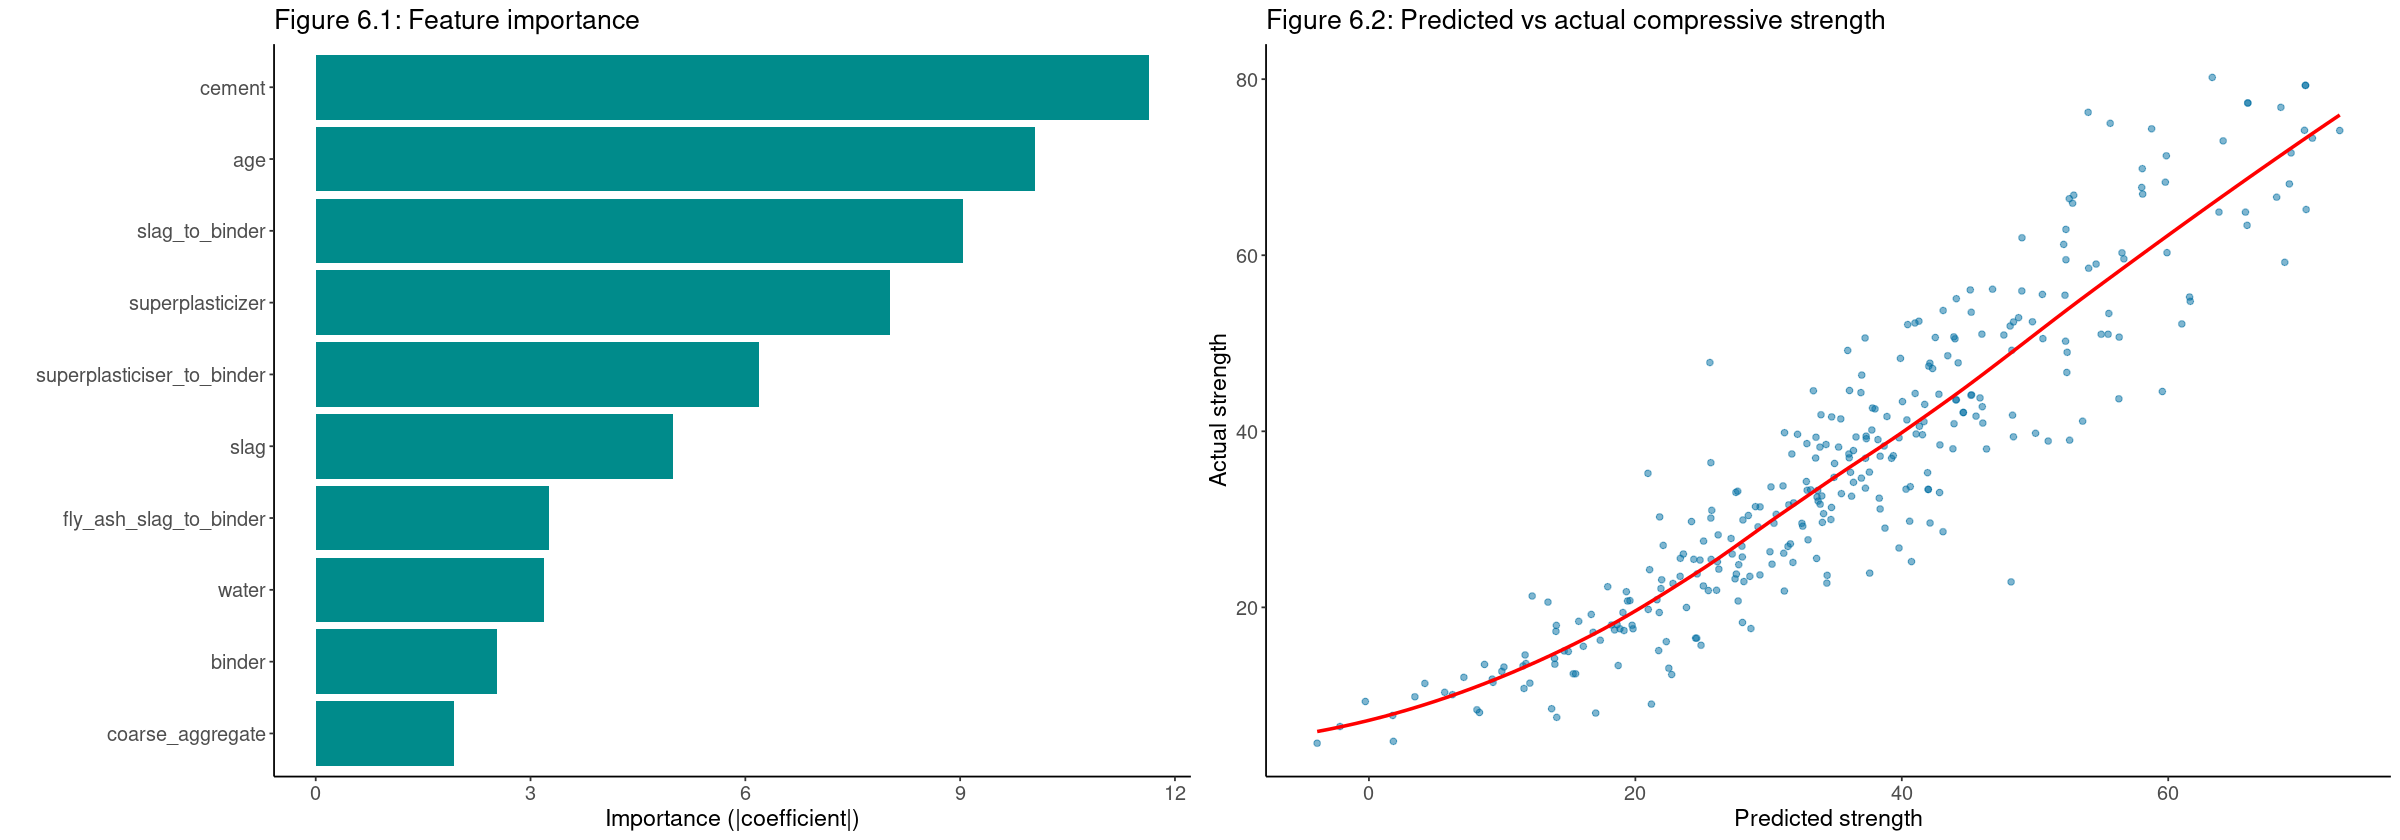

In [62]:
# view variable importance on the fitted data
p1 <- vip(glm2_fit, aesthetics = list(fill = "darkcyan"), include_type = TRUE) + 
    labs(title = "Figure 6.1: Feature importance") + 
    theme_report()

p2 <- ggplot(glm2_preds, aes(.pred, strength)) +
    geom_point(color = '#006EA1', alpha = 0.5) +
    geom_smooth(se = FALSE, colour = "red") +
#   geom_abline(intercept = 0, slope = 1, color = 'red') +
    labs(title = 'Figure 6.2: Predicted vs actual compressive strength',
         x = 'Predicted strength',
         y = 'Actual strength') +
    theme_report()

options(repr.plot.width=20, repr.plot.height=NULL)
plot_grid(p1, p2)